# Trabajo Práctico 1

Asignatura: Análisis de Series Temporales

Docente: Rodrigo Del Rosso

Asistentes: Sebastian Calcagno - Fernando Martinez

# Integrantes:
* Del Villar, Javier Alonso
* Otrino, Facundo Damián
* Pistoya, Haydeé Soledad
* Rojas, Mariano Arturo
* Sorza, Edwin Andrés
* Vaillard, Leandro Carlos

In [1]:
library(astsa)
library(dygraphs)
library(forecast)
library(fpp)
library(ggplot2)
library(gridExtra)
library(MLmetrics)
library(PerformanceAnalytics)
library(Quandl)
library(quantmod)
library(rlang)
library(tseries)
library(urca)
library(readr)
library(nortest)
library(lessR)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: ‘forecast’


The following object is masked from ‘package:astsa’:

    gas


Loading required package: fma


Attaching package: ‘fma’


The following objects are masked from ‘package:astsa’:

    chicken, sales


Loading required package: expsmooth

Loading required package: lmtest

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Loading required package: tseries


Attaching package: ‘fpp’


The following object is masked from ‘package:astsa’:

    oil



Attaching package: ‘MLmetrics’


The following object is masked from ‘package:base’:

    Recall


Loading required package: xts


Attaching package: ‘PerformanceAnalytics’


The following object is masked from ‘package:graphics’:

    legend


Loading required package: TTR


lessR 3.9.9  feedback: gerbing@pdx.edu  web: le

In [2]:
# Funci?n para construir una matriz con los valores de AIC
AIC_Matrix <- function(ts, p.order, q.order) {
  # require(forecast)
  aic_matrix <- matrix(data = NA, nrow = p.order, ncol = q.order)
  max_i <- p.order - 1
  max_j <- q.order - 1
  for (i in 0:max_i) {
    for (j in 0:max_j) {
      aic <- arima(ts, order = c(i, 0, j))$aic
      a <- i + 1
      b <- j + 1
      aic_matrix[a, b] <- aic
    }
  }
  rownames(aic_matrix) <- c(0:max_i)
  colnames(aic_matrix) <- c(0:max_j)
  return(aic_matrix)
}

# Funci?n para testear normalidad
Normality_Test <- function(ts, type = c("JB", "AD", "SW")) {
  # require(tseries)
  # require(nortest)
  if (type == "JB") {
    p_val <- jarque.bera.test(ts)$p.value
    stat <- jarque.bera.test(ts)$statistic
  } else if (type == "AD") {
    p_val <- ad.test(ts)$p.value
    stat <- ad.test(ts)$statistic
  } else {
    p_val <- shapiro.test(ts)$p.value
    stat <- shapiro.test(ts)$statistic
  }
  table <- data.frame(
    P_Value = p_val,
    Statistic = stat
  )
  return(table)
}

# Funci?n de Incorrelaci?n
Incorrelation <- function(ts, type = c("Ljung-Box", "Box-Pierce"), fitdf = 0) {
  p_ljung_box <- NULL
  s_ljung_box <- NULL
  for (i in 0:(length(ts) / 4)) {
    p_ljung_box[i] <- Box.test(ts, lag = i, type = type, fitdf = fitdf)$p.value
    s_ljung_box[i] <- Box.test(ts, lag = i, type = type, fitdf = fitdf)$statistic
  }
  table <- data.frame(
    j = 1:(length(ts) / 4),
    P_Value = p_ljung_box,
    Statistic = s_ljung_box
  )
  return(table)
}

# Alternativa de funci?n de Incorrelaci?n
Incorrelation2 <- function(ts, type = c("Ljung-Box", "Box-Pierce"), fitdf = 0) {
  if (is.ts(ts)) {
    p_ljung_box <- NULL
    s_ljung_box <- NULL
    for (i in 0:(length(ts) / 4)) {
      p_ljung_box[i] <- Box.test(ts, lag = i, type = type, fitdf = fitdf)$p.value
      s_ljung_box[i] <- Box.test(ts, lag = i, type = type, fitdf = fitdf)$statistic
    }
    table <- data.frame(
      id = 1:(length(ts) / 4),
      P_Value = p_ljung_box,
      Statistic = s_ljung_box
    )
    return(table)
  } else {
    print("El objeto no es una serie de tiempo")
  }
}

# Funci?n para testear Estacionalidad
is_stationary <- function(adf_test, p_Valor = 0.05) {
  if (adf_test$p.value >= p_Valor) {
    print("No rechazo la hip?tesis nula, la serie no es estacionaria")
  } else {
    print("Rechazo la hip?tesis nula, la serie es estacionaria")
  }
}

In [3]:
# Lectura de Datos y creaci?n de varaibles

imported <- read_csv("data/serie-tiempo-indicadores-mensuales-bovinos.csv",
                     col_types = cols(indice_tiempo = col_date(format = "%Y-%m")))


serie <- ts(imported$faena_total_pais / 1000000, frequency = 12, start = c(1998, 01))

log_serie <- log10(serie)

diff_log_serie <- diff(log_serie)

diff12_log_serie <- diff(log_serie, 12)
diff12_log_serie <- diff(log_serie, 12)

diff12_1_log_serie <- diff(diff12_log_serie)

### Data Overview

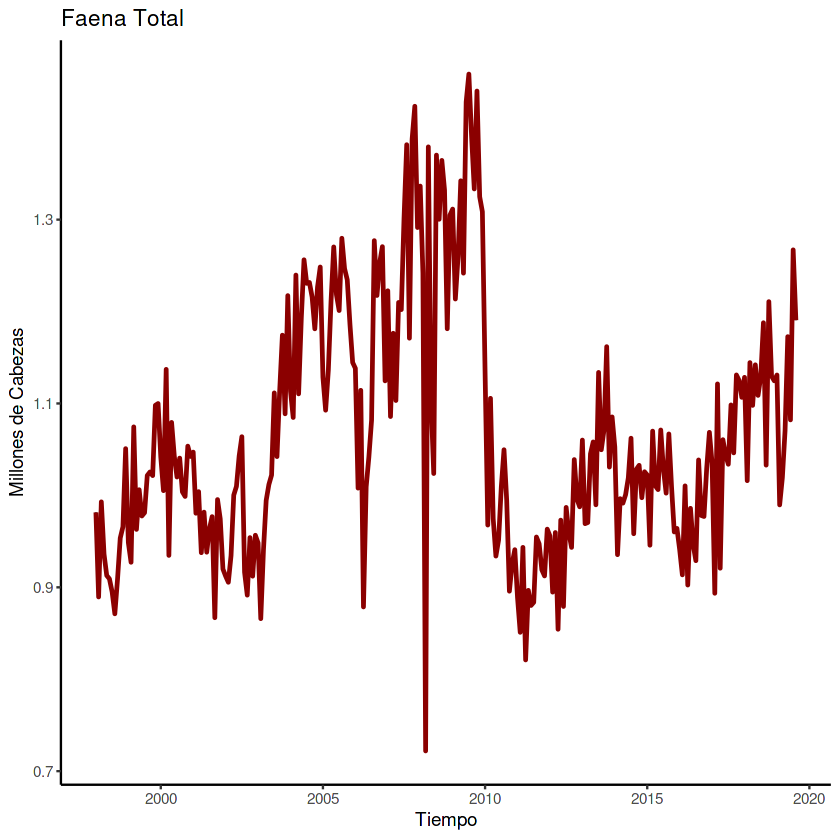

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.722   0.964   1.037   1.065   1.136   1.458 

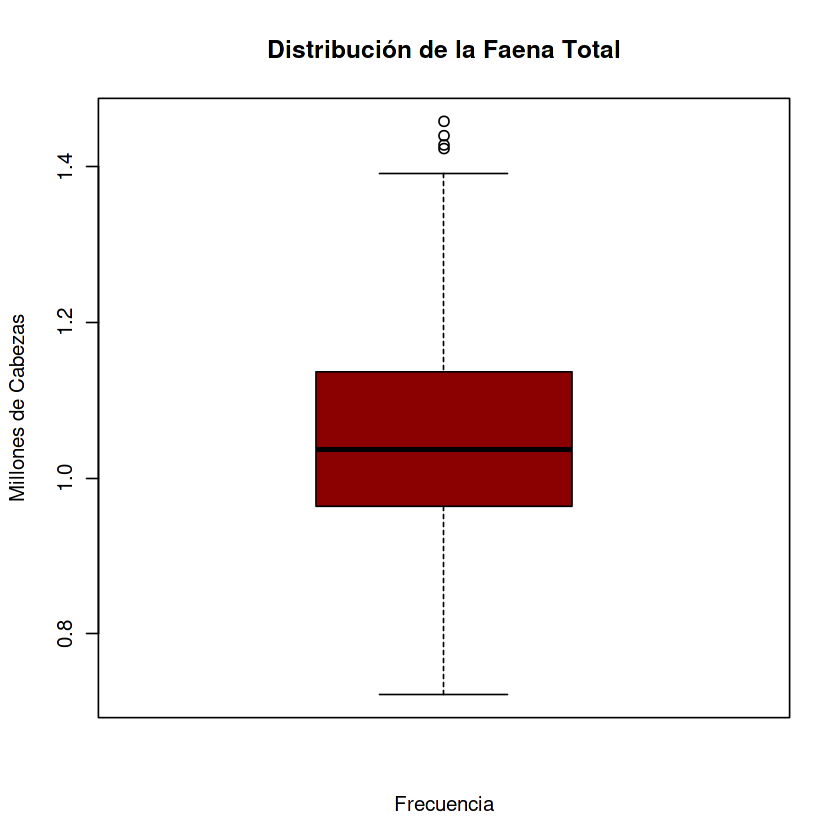

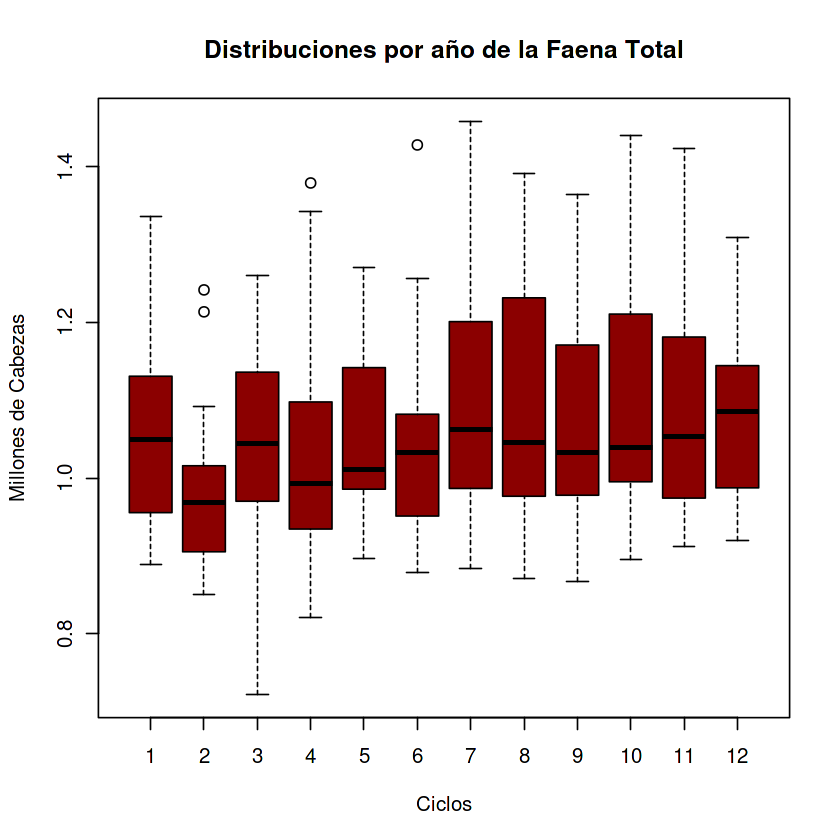

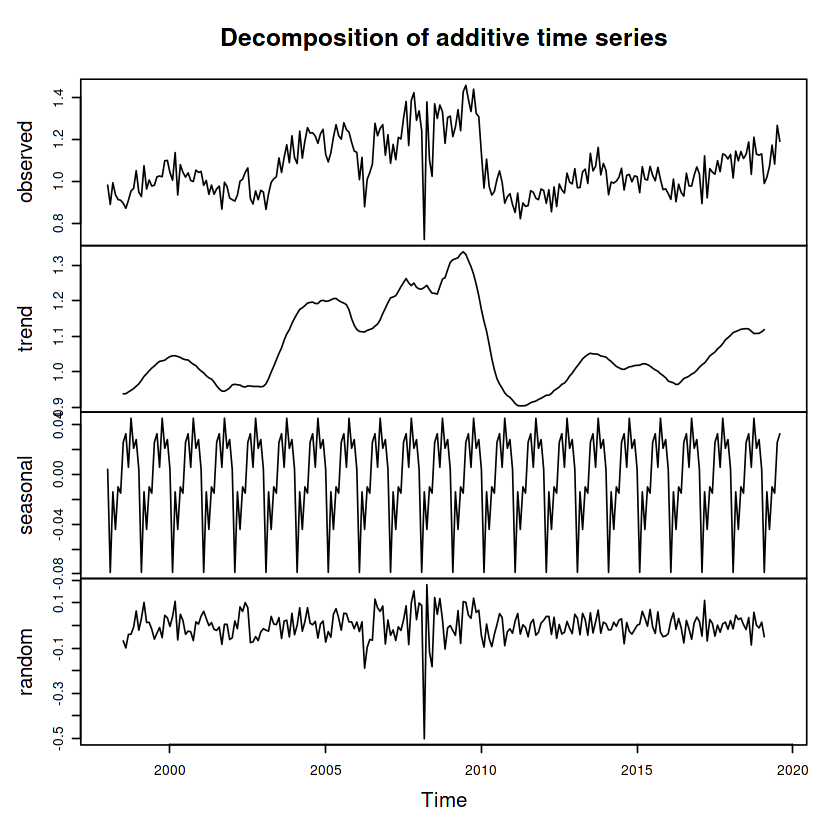

In [4]:
autoplot(
  serie,
  main = "Faena Total",
  xlab = "Tiempo",
  ylab = "Millones de Cabezas"
) + geom_line(size = 1, color = "darkred") +  theme_classic()

boxplot(
  serie,
  main = "Distribución de la Faena Total",
  xlab = "Frecuencia",
  ylab = "Millones de Cabezas",
  col = "darkred"
)

 summary(serie)

# Boxplot de la serie seg?n el a?o
boxplot(
  serie ~ cycle(serie),
  main = "Distribuciones por año de la Faena Total",
  xlab = "Ciclos",
  ylab = "Millones de Cabezas",
  col = "darkred"
)

# Descomposición de la Serie
plot(decompose(serie))

### Gr?ficos de la serie y sus transformaciones

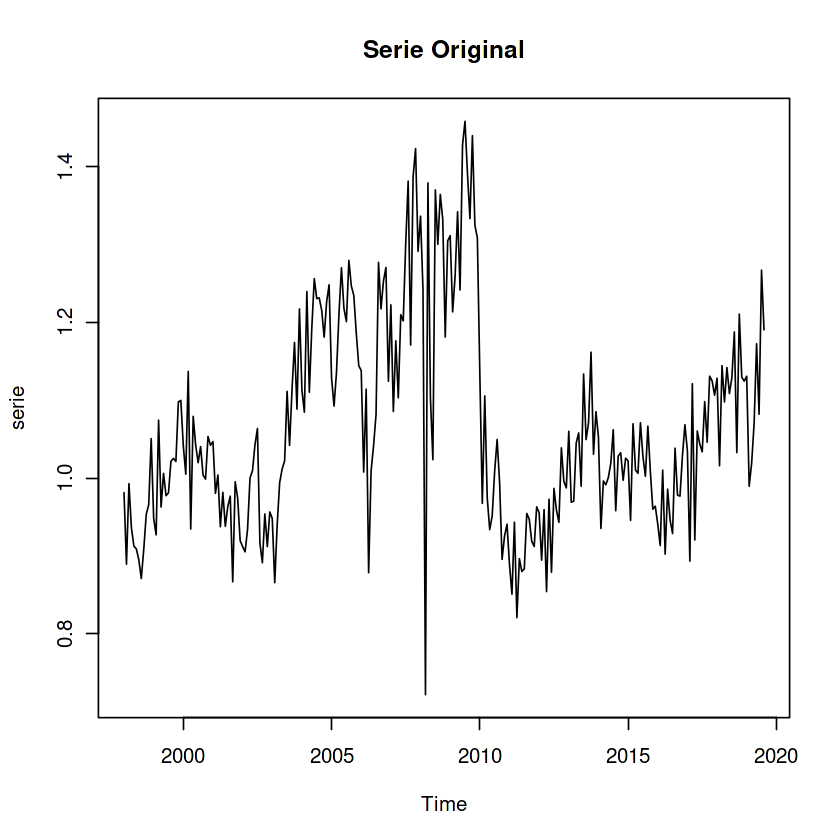

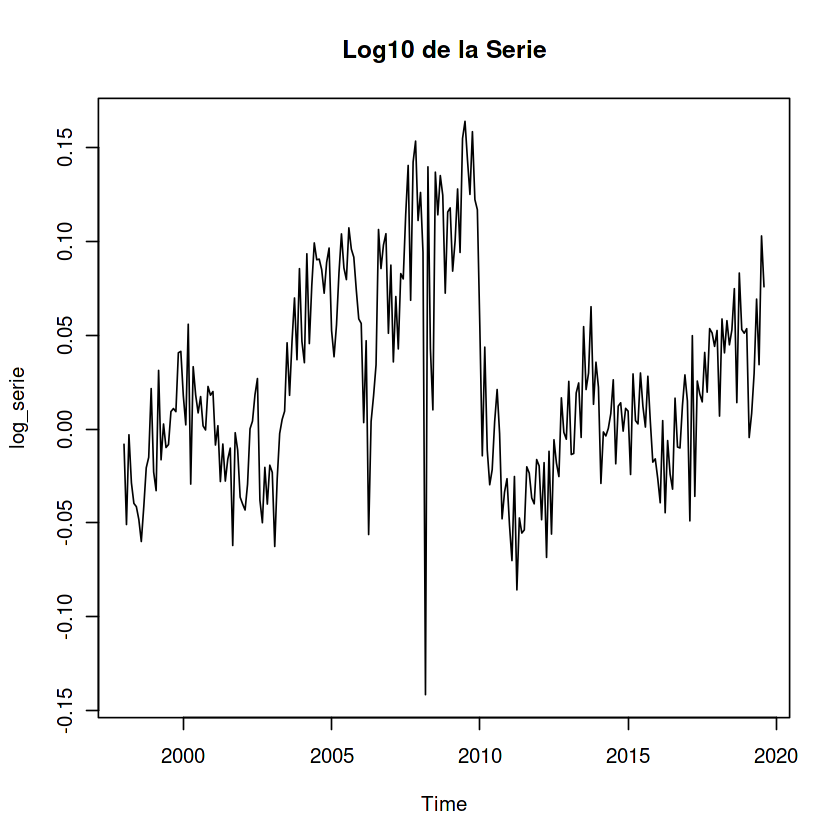

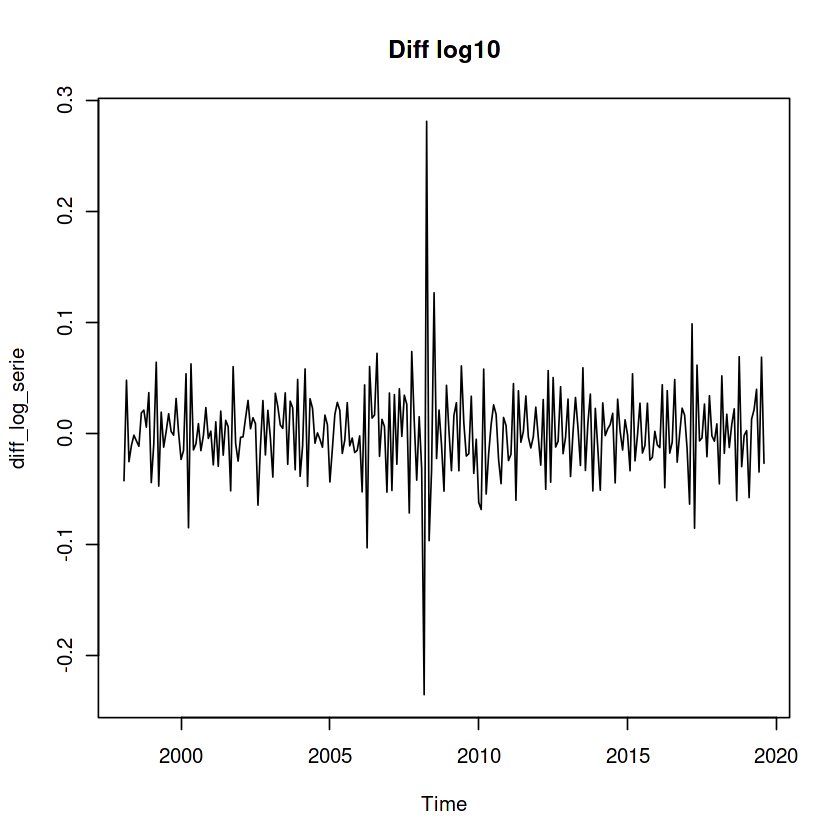

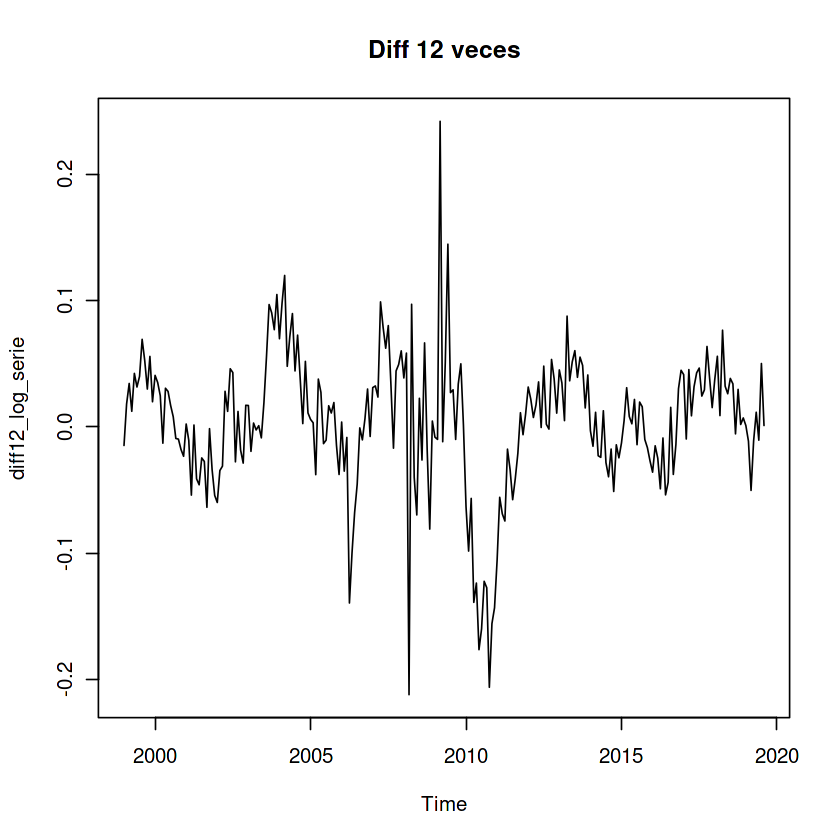

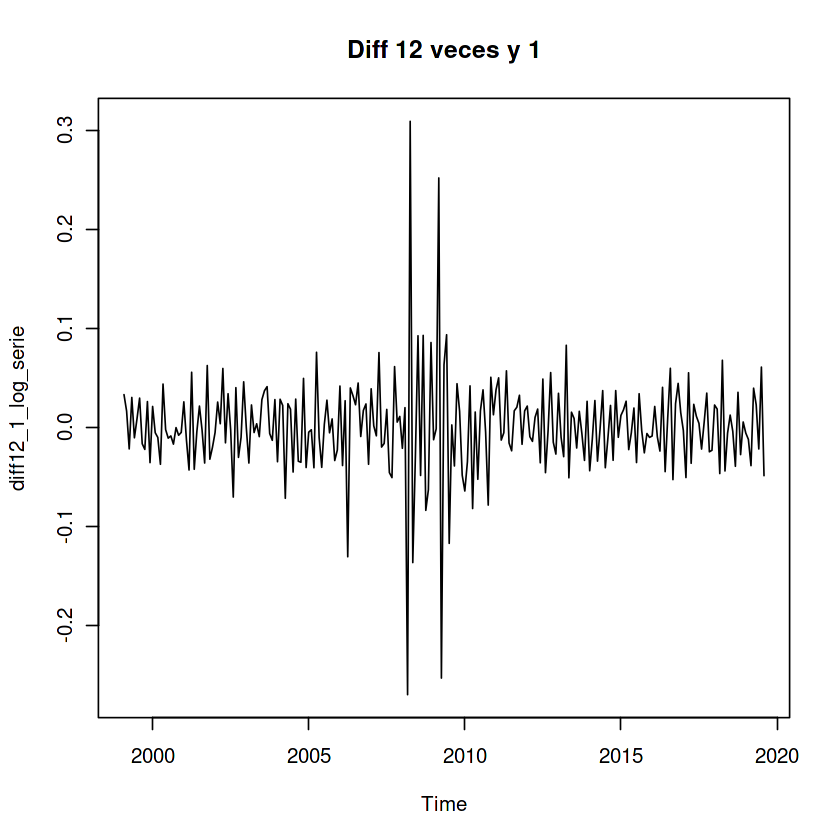

In [5]:
plot(serie, main = "Serie Original")

plot(log_serie, main = "Log10 de la Serie")

plot(diff_log_serie, main = "Diff log10") # Diferencia de 1 mes atras  en log para remove estacionariedad (stationary)

plot(diff12_log_serie, main = "Diff 12 veces") # Diferencia de 12 meses atras  en log seasonal

plot(diff12_1_log_serie, main = "Diff 12 veces y 1") # se ataca el stacionary y el seasonal 

# Explicar test durbin-watson, test de haydy(para detectar estacionalidad) & xq hicimos la diff.

# Gr?ficos de la ACF y Partial ACF

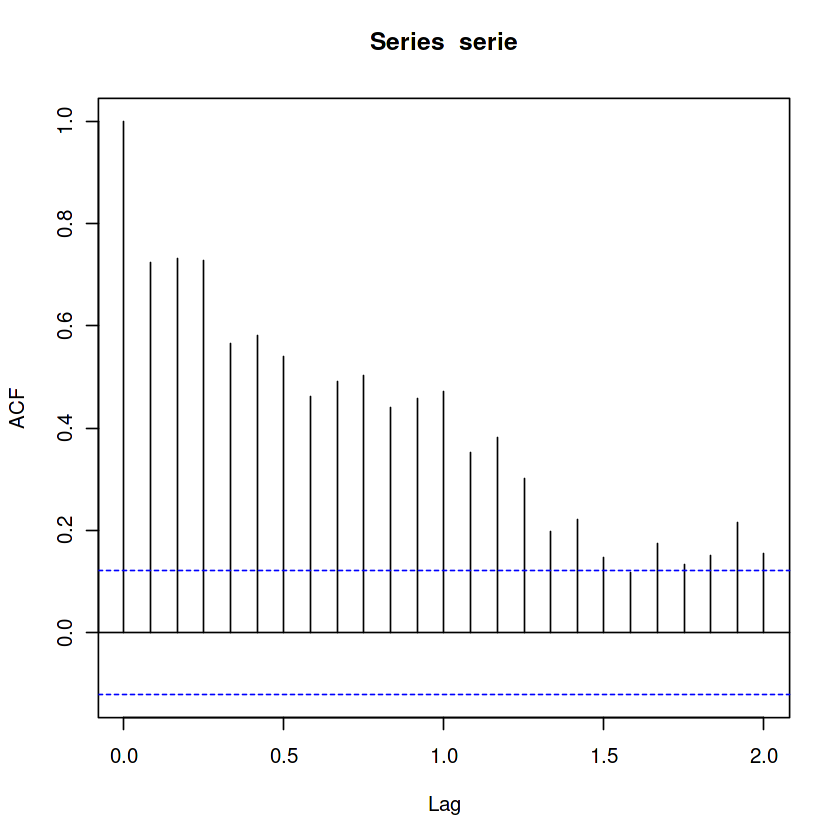

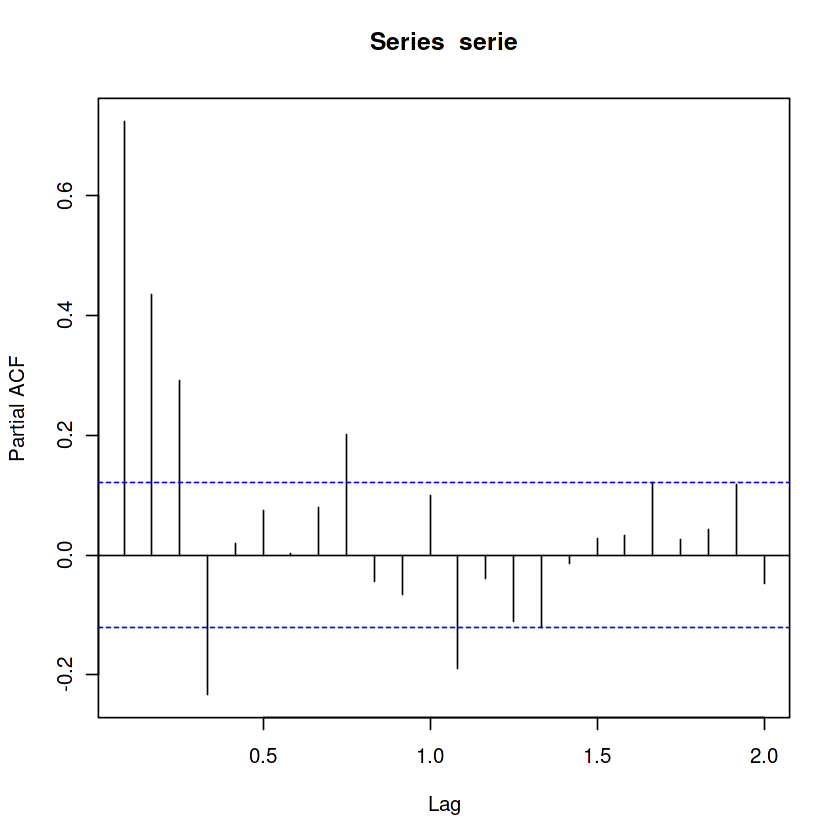

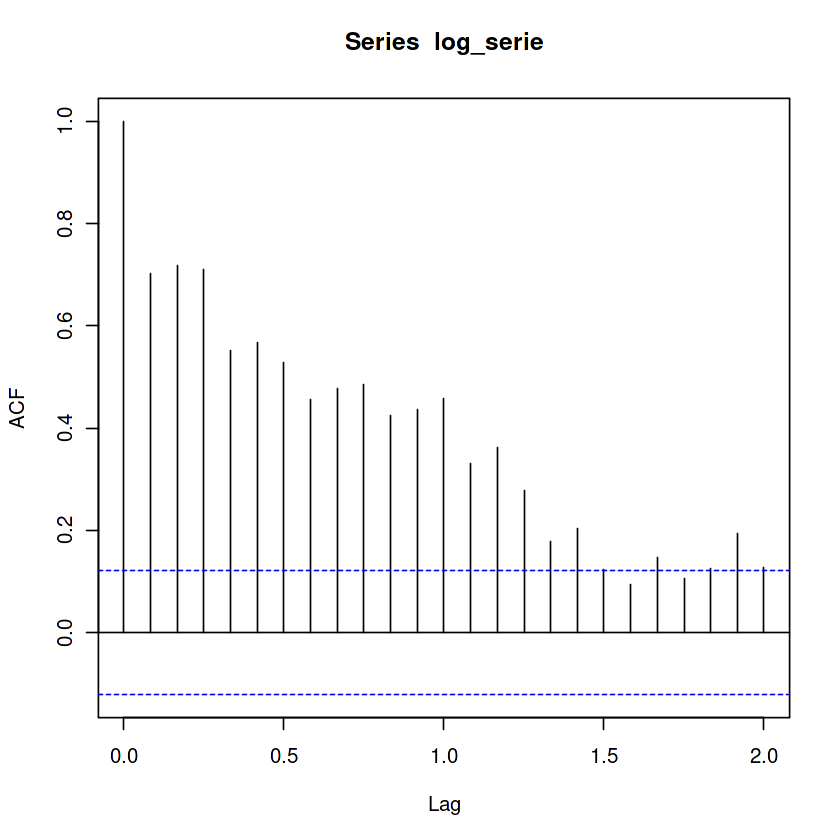

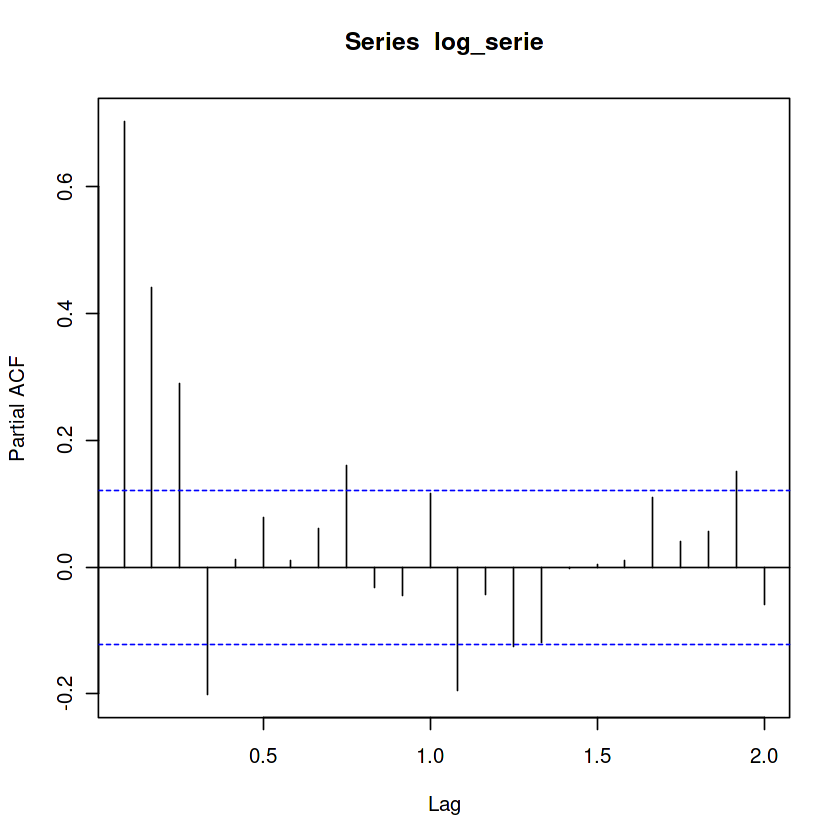

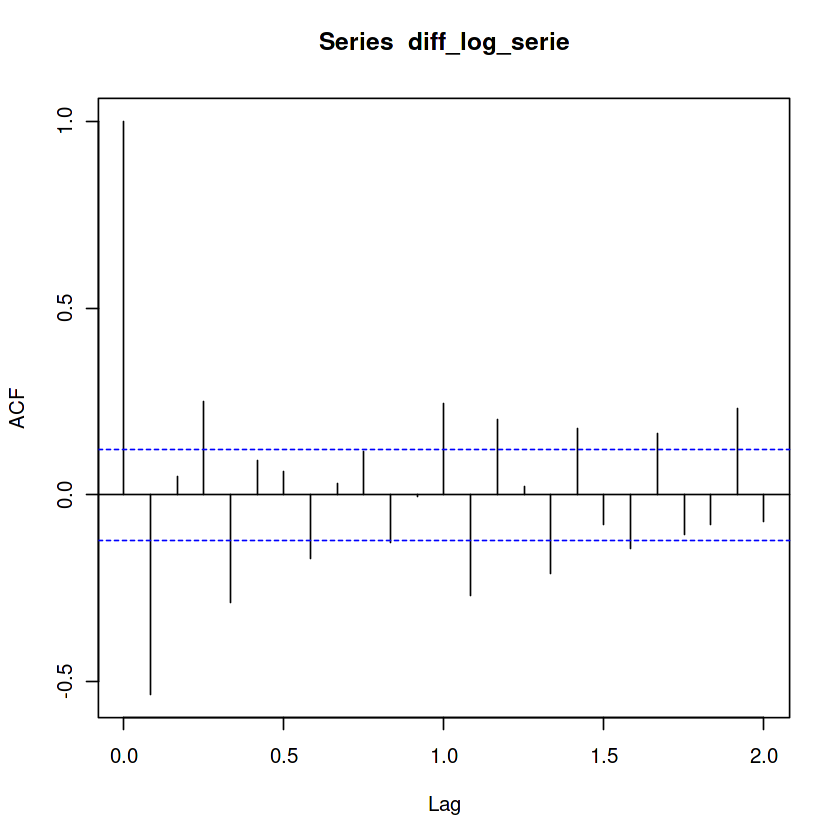

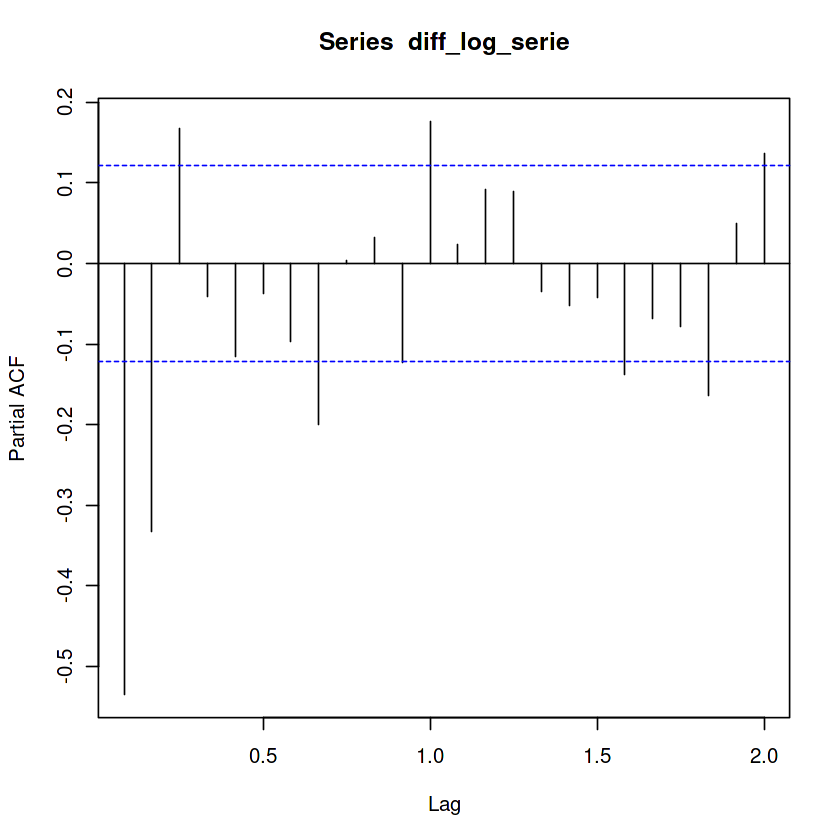

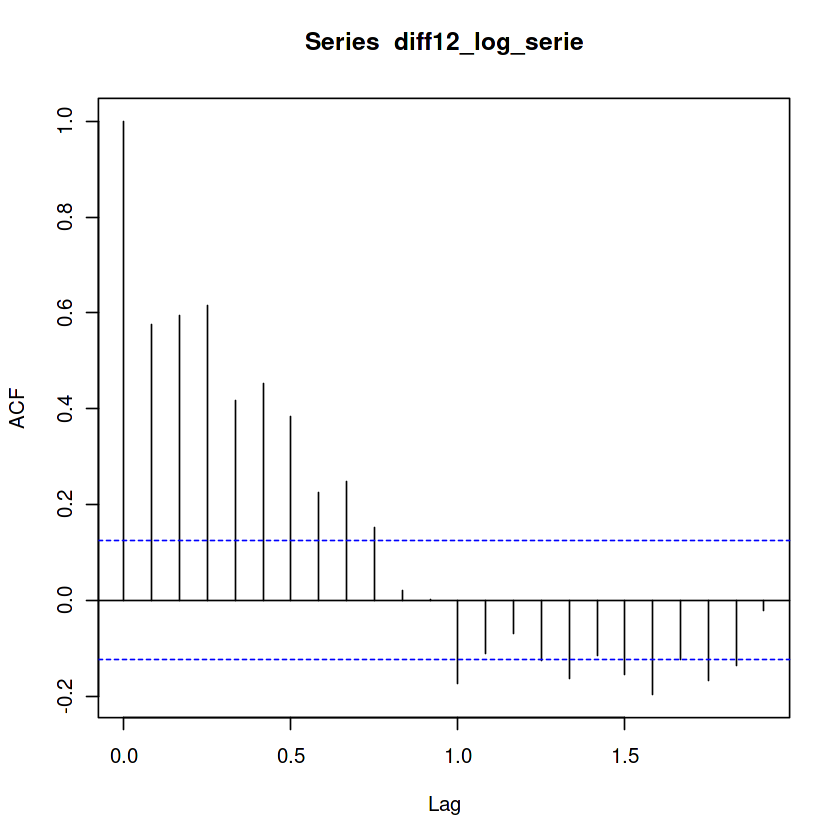

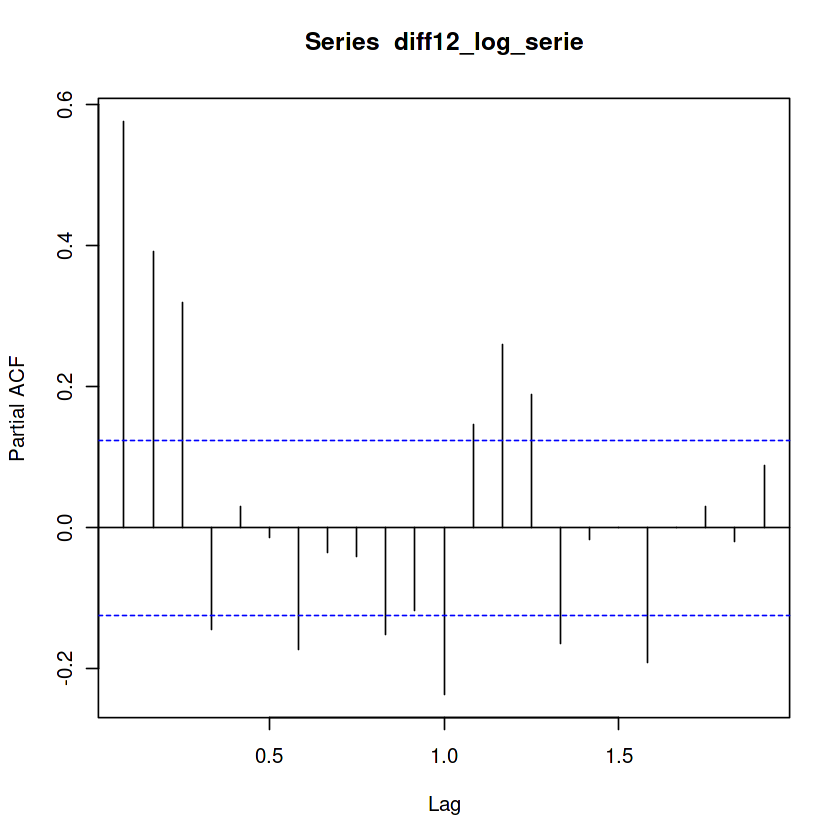

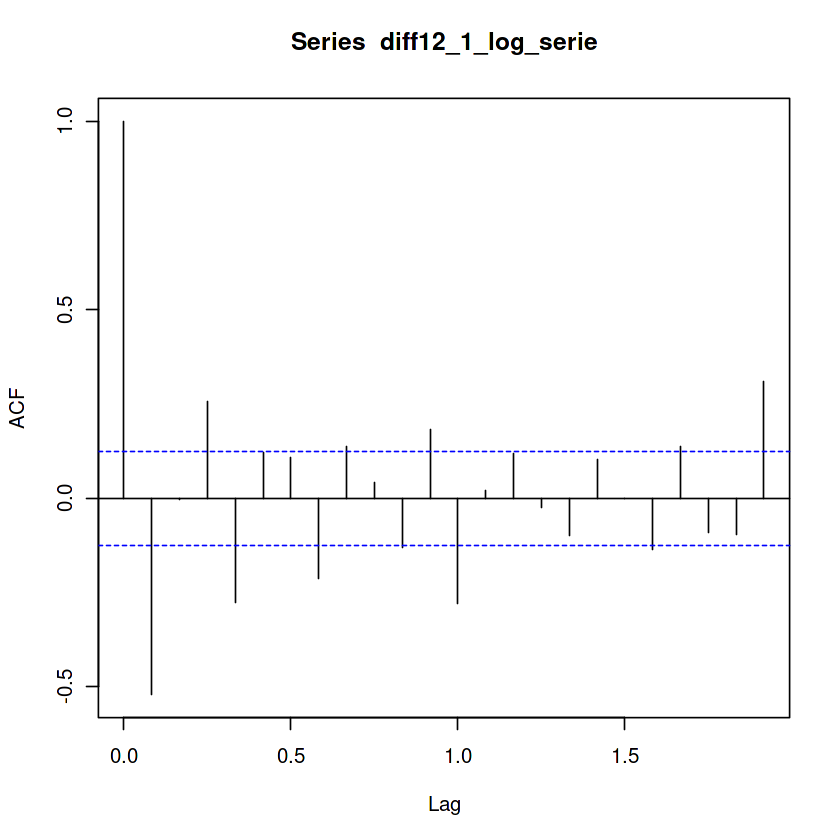

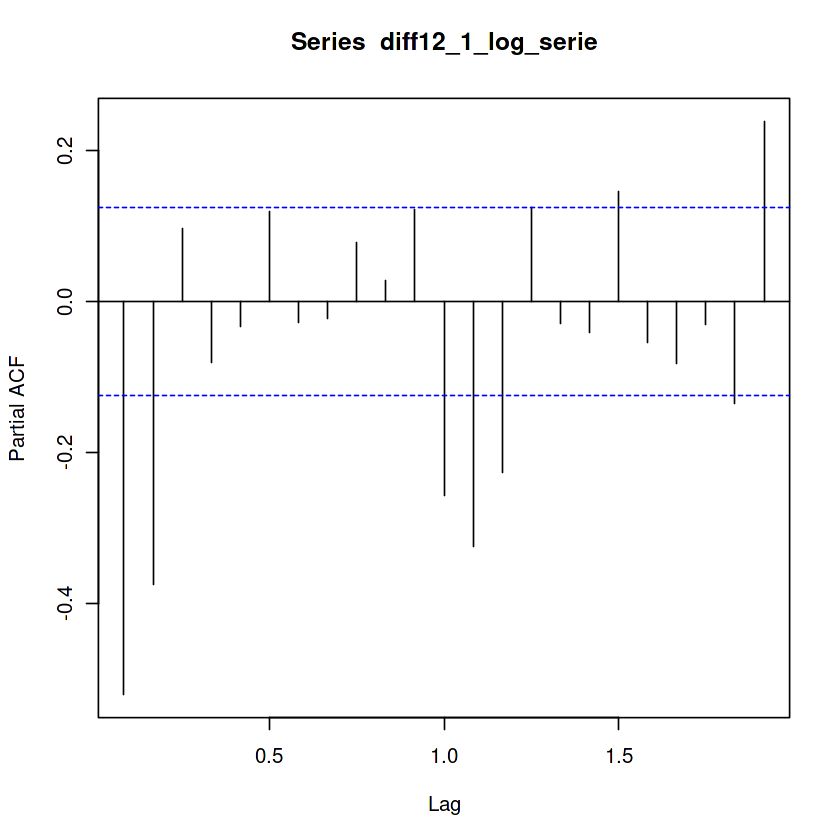

In [6]:
acf(serie)
pacf(serie)

acf(log_serie)
pacf(log_serie)

acf(diff_log_serie)
pacf(diff_log_serie)

acf(diff12_log_serie)
pacf(diff12_log_serie)

acf(diff12_1_log_serie)
pacf(diff12_1_log_serie)

### Test de Raices Unitarias

#### 1) Hipótesis de Dickey Fuller para probar estacionaridad
* H0: La serie tiene ra?ces unitarias (no es estacionaria)
* H1: La serie no tiene ra?ces unitarias (es estacionaria)

In [7]:
# Serie Original
adf_test <- adf.test(serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)

# Log Serie Original
adf_test <- adf.test(log_serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)

# Primera Diferencia sobre Log10 Serie Original
adf_test <- adf.test(diff_log_serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)

# Primera Diferencia estacional sobre Log10 Serie Original
adf_test <- adf.test(diff12_log_serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)

# Primera Diferencia sobre una serie diferenciada estacionalmente que ya tuvo Log10
adf_test <- adf.test(diff12_1_log_serie, alternative = "stationary", k = 12)
print(adf_test)
is_stationary(adf_test)


	Augmented Dickey-Fuller Test

data:  serie
Dickey-Fuller = -2.3885, Lag order = 12, p-value = 0.4123
alternative hypothesis: stationary

[1] "No rechazo la hip?tesis nula, la serie no es estacionaria"

	Augmented Dickey-Fuller Test

data:  log_serie
Dickey-Fuller = -2.3876, Lag order = 12, p-value = 0.4126
alternative hypothesis: stationary

[1] "No rechazo la hip?tesis nula, la serie no es estacionaria"

	Augmented Dickey-Fuller Test

data:  diff_log_serie
Dickey-Fuller = -4.6299, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary

[1] "Rechazo la hip?tesis nula, la serie es estacionaria"

	Augmented Dickey-Fuller Test

data:  diff12_log_serie
Dickey-Fuller = -4.6274, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary

[1] "Rechazo la hip?tesis nula, la serie es estacionaria"

	Augmented Dickey-Fuller Test

data:  diff12_1_log_serie
Dickey-Fuller = -6.4796, Lag order = 12, p-value = 0.01
alternative hypothesis: stationary

[1] "Rechazo la hip?tesis nula

### Investigar

In [8]:
#Investigar un poco mas de este test........
# hegy.test(serie)
# hegy.test(log_serie)
# hegy.test(diff_log_serie)
# hegy.test(diff12_log_serie)
# hegy.test(diff12_1_log_serie)


# Test sobre el Log10 de la serie original
none.df <- ur.df(log_serie, type = "none", selectlags = c("AIC"))
drift.df <- ur.df(log_serie, type = "drift", selectlags = c("AIC"))
trend.df <- ur.df(log_serie, type = "trend", selectlags = c("AIC"))

summary(none.df)
summary(drift.df)
summary(trend.df)


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.238837 -0.013273  0.004725  0.023445  0.152205 

Coefficients:
           Estimate Std. Error t value            Pr(>|t|)
z.lag.1    -0.12477    0.03882  -3.214             0.00148
z.diff.lag -0.47220    0.05533  -8.534 0.00000000000000126

Residual standard error: 0.03426 on 256 degrees of freedom
Multiple R-squared:  0.3157,	Adjusted R-squared:  0.3104 
F-statistic: 59.05 on 2 and 256 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -3.2139 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.239466 -0.017489  0.000672  0.018262  0.146649 

Coefficients:
             Estimate Std. Error t value           Pr(>|t|)
(Intercept)  0.004540   0.002354   1.929           0.054894
z.lag.1     -0.160529   0.042838  -3.747           0.000221
z.diff.lag  -0.455034   0.055753  -8.162 0.0000000000000152

Residual standard error: 0.03408 on 255 degrees of freedom
Multiple R-squared:  0.3254,	Adjusted R-squared:  0.3201 
F-statistic: 61.51 on 2 and 255 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -3.7473 7.079 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.239389 -0.017290  0.000507  0.018193  0.146654 

Coefficients:
                Estimate   Std. Error t value           Pr(>|t|)
(Intercept)  0.003848856  0.004370566   0.881           0.379350
z.lag.1     -0.160921851  0.042970538  -3.745           0.000223
tt           0.000005367  0.000028579   0.188           0.851193
z.diff.lag  -0.454909305  0.055862871  -8.143 0.0000000000000174

Residual standard error: 0.03415 on 254 degrees of freedom
Multiple R-squared:  0.3255,	Adjusted R-squared:  0.3176 
F-statistic: 40.86 on 3 and 254 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -3.7449 4.7132 7.0123 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -3.98 -

#### 2) KPSS - 
* H0: Estacionario
* H1: No estacionario

XAV: NO ENTEND? ESTE TEST LA P VALOR ES 0.1???

H0 Y H1 SON AL REV?S AHORA?

In [9]:
kpss_test <- kpss.test(log_serie)
print(kpss_test)
#is_stationary(kpss_test, 0.1)

# Diferenciar una vez
ndiffs(log_serie)

# Diferenciar estacionalmente una vez
nsdiffs(log_serie)

# Test sobre la diff 12 y una diff sobre la Serie original
none.df <- ur.df(diff12_1_log_serie, type = "none", selectlags = c("AIC"))
drift.df <- ur.df(diff12_1_log_serie, type = "drift", selectlags = c("AIC"))
trend.df <- ur.df(diff12_1_log_serie, type = "trend", selectlags = c("AIC"))

summary(none.df)
summary(drift.df)
summary(trend.df)

# ESTACIONARIO
kpss_test <- kpss.test(diff12_1_log_serie)
print(kpss_test)
# is_stationary(kpss_test, 0.1)
# p-value = 0.1 - no Rechazo H0, estacionario


	KPSS Test for Level Stationarity

data:  log_serie
KPSS Level = 0.37363, Truncation lag parameter = 5, p-value = 0.08852



[1] 1

[1] 0


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.264248 -0.019002  0.001795  0.019544  0.245640 

Coefficients:
           Estimate Std. Error t value             Pr(>|t|)
z.lag.1    -2.09749    0.10359 -20.248 < 0.0000000000000002
z.diff.lag  0.37763    0.05948   6.349        0.00000000106

Residual standard error: 0.04036 on 243 degrees of freedom
Multiple R-squared:  0.7952,	Adjusted R-squared:  0.7935 
F-statistic: 471.6 on 2 and 243 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -20.2481 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.26421 -0.01897  0.00183  0.01958  0.24568 

Coefficients:
               Estimate  Std. Error t value             Pr(>|t|)
(Intercept) -0.00003513  0.00258407  -0.014                0.989
z.lag.1     -2.09748662  0.10380368 -20.206 < 0.0000000000000002
z.diff.lag   0.37762602  0.05960461   6.336        0.00000000114

Residual standard error: 0.04045 on 242 degrees of freedom
Multiple R-squared:  0.7952,	Adjusted R-squared:  0.7935 
F-statistic: 469.7 on 2 and 242 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -20.2063 204.1496 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.46 -2.88 -2.57
phi1  6.52  4.63  3.81



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.264122 -0.018802  0.001555  0.019828  0.245693 

Coefficients:
                Estimate   Std. Error t value             Pr(>|t|)
(Intercept) -0.000774695  0.005226305  -0.148                0.882
z.lag.1     -2.097554825  0.104013937 -20.166 < 0.0000000000000002
tt           0.000005964  0.000036612   0.163                0.871
z.diff.lag   0.377624691  0.059724856   6.323        0.00000000124

Residual standard error: 0.04053 on 241 degrees of freedom
Multiple R-squared:  0.7952,	Adjusted R-squared:  0.7926 
F-statistic: 311.9 on 3 and 241 DF,  p-value: < 0.00000000000000022


Value of test-statistic is: -20.1661 135.5611 203.339 

Critical values for test statistics: 
      1pct  5pct 10pc


	KPSS Test for Level Stationarity

data:  diff12_1_log_serie
KPSS Level = 0.020598, Truncation lag parameter = 5, p-value = 0.1



### Particion de Datos: Train & Test

In [10]:
train <- window(log_serie, start = 2011, end = c(2017, 12), frequency = 12)
test <- window(log_serie, start = c(2018,01), end = c(2018,12))

# no fue usado en el trabajo final, pero si como prueba
train_2 <- window(diff_log_serie, start = 2011, end = c(2017, 12), frequency = 12)
test_2 <- window(diff_log_serie, start = c(2018,01), end = c(2018,12))

### Prediccion

#### Promedio Simple

         Point Forecast       Lo 80      Hi 80       Lo 95      Hi 95
Jan 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Feb 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Mar 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Apr 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
May 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Jun 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Jul 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Aug 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Sep 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Oct 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Nov 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557
Dec 2018   -0.003658711 -0.04456068 0.03724325 -0.06663299 0.05931557

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.0000000000000000005289519,0.03128721,0.02542715,108.1741,119.5344,0.9126343,0.4267791,NA
Test set,0.0528048886313588552998688,0.05669808,0.05280489,112.1664,112.1664,1.8952794,-0.5088417,1.249533


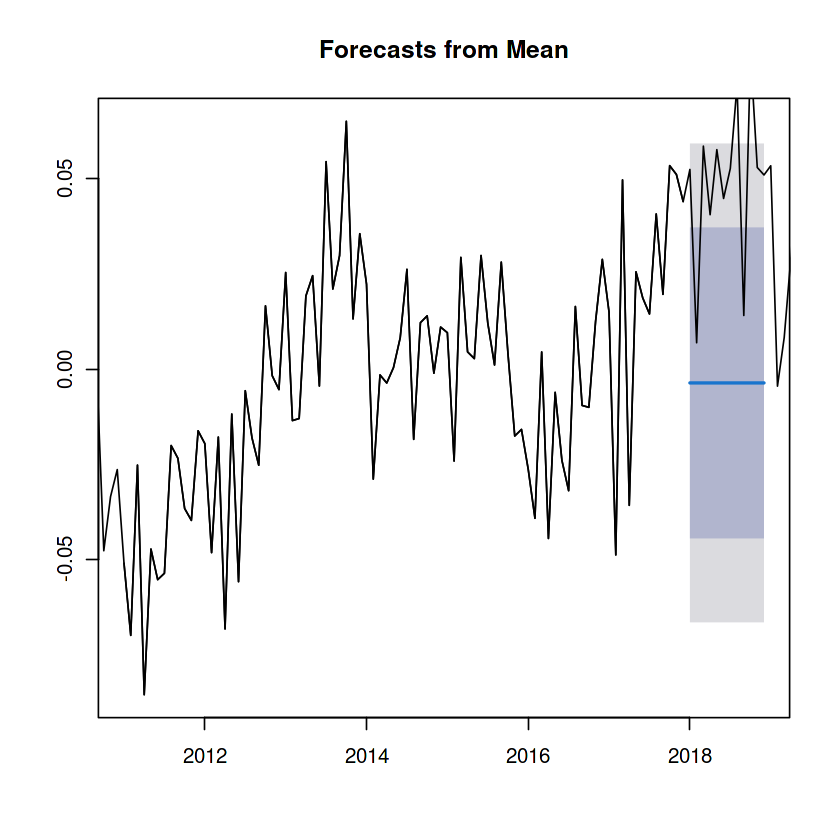

In [11]:
simple_average <- meanf(train, h = 12)
simple_average

accuracy(simple_average, test)

plot(simple_average, type = "l")
lines(log_serie)

#### Naive Bayes

         Point Forecast        Lo 80      Hi 80       Lo 95     Hi 95
Jan 2018     0.04402873  0.001887694 0.08616977 -0.02042042 0.1084779
Feb 2018     0.04402873 -0.015567696 0.10362516 -0.04711614 0.1351736
Mar 2018     0.04402873 -0.028961687 0.11701915 -0.06760048 0.1556579
Apr 2018     0.04402873 -0.040253344 0.12831081 -0.08486958 0.1729270
May 2018     0.04402873 -0.050201494 0.13825896 -0.10008396 0.1881414
Jun 2018     0.04402873 -0.059195309 0.14725277 -0.11383882 0.2018963
Jul 2018     0.04402873 -0.067465975 0.15552344 -0.12648771 0.2145452
Aug 2018     0.04402873 -0.075164124 0.16322159 -0.13826101 0.2263185
Sep 2018     0.04402873 -0.082394383 0.17045185 -0.14931874 0.2373762
Oct 2018     0.04402873 -0.089232932 0.17729040 -0.15977740 0.2478349
Nov 2018     0.04402873 -0.095737280 0.18379475 -0.16972494 0.2577824
Dec 2018     0.04402873 -0.101952107 0.19000957 -0.17922970 0.2672872

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.001145761,0.03288283,0.02574392,32.58097,220.96688,0.9240040,-0.6732533,NA
Test set,0.005117445,0.02127213,0.01687034,-46.40922,80.02872,0.6055121,-0.5088417,0.4028334


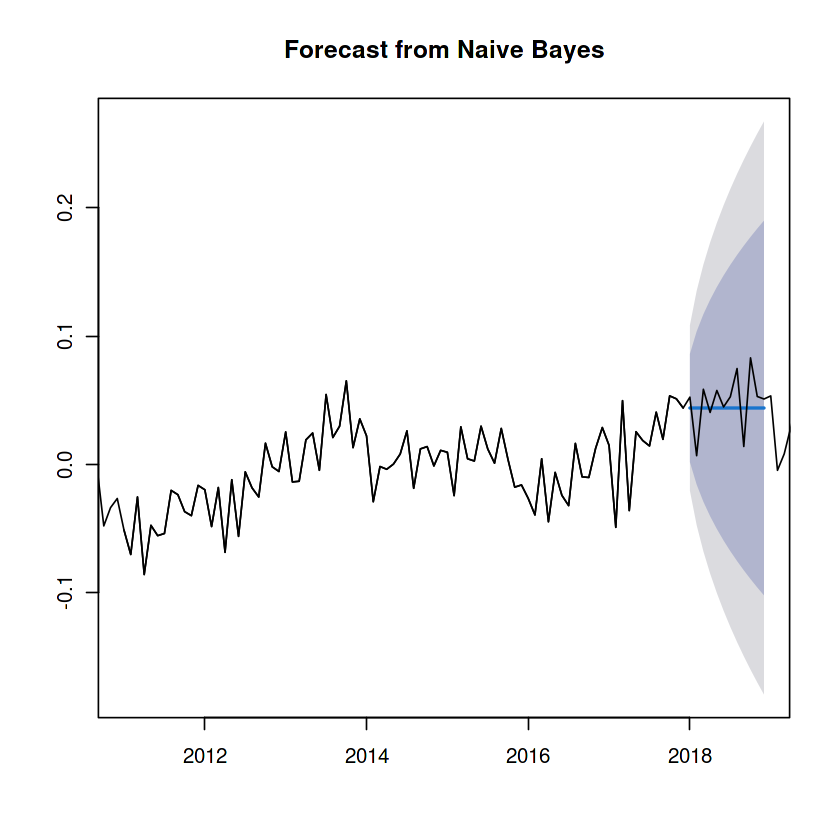

In [12]:
naive_ingenuo <- rwf(train, h = 12)
naive_ingenuo

accuracy(naive_ingenuo, test)

plot(naive_ingenuo, type = "l", main = "Forecast from Naive Bayes")
lines(log_serie)

#### Naive Estacional

         Point Forecast        Lo 80        Hi 80       Lo 95      Hi 95
Jan 2018     0.01494371 -0.027464728  0.057352141 -0.04991440 0.07980181
Feb 2018    -0.04888163 -0.091290061 -0.006473193 -0.11373973 0.01597648
Mar 2018     0.04970904  0.007300606  0.092117475 -0.01514906 0.11456714
Apr 2018    -0.03583988 -0.078248312  0.006568557 -0.10069798 0.02901823
May 2018     0.02554794 -0.016860497  0.067956372 -0.03931017 0.09040604
Jun 2018     0.01868968 -0.023718751  0.061098117 -0.04616842 0.08354779
Jul 2018     0.01447349 -0.027934940  0.056881929 -0.05038461 0.07933160
Aug 2018     0.04075855 -0.001649887  0.083166981 -0.02409956 0.10561665
Sep 2018     0.01964626 -0.022762171  0.062054698 -0.04521184 0.08450437
Oct 2018     0.05347220  0.011063770  0.095880639 -0.01138590 0.11833031
Nov 2018     0.05115252  0.008744088  0.093560957 -0.01370558 0.11601063
Dec 2018     0.04402873  0.001620298  0.086437167 -0.02082937 0.10888684

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.01073033,0.03309148,0.02786127,-62.99054,345.2460,1.000000,0.5362879,NA
Test set,0.02850446,0.03621281,0.02943229,110.66871,117.2587,1.056387,-0.1188770,0.3644801


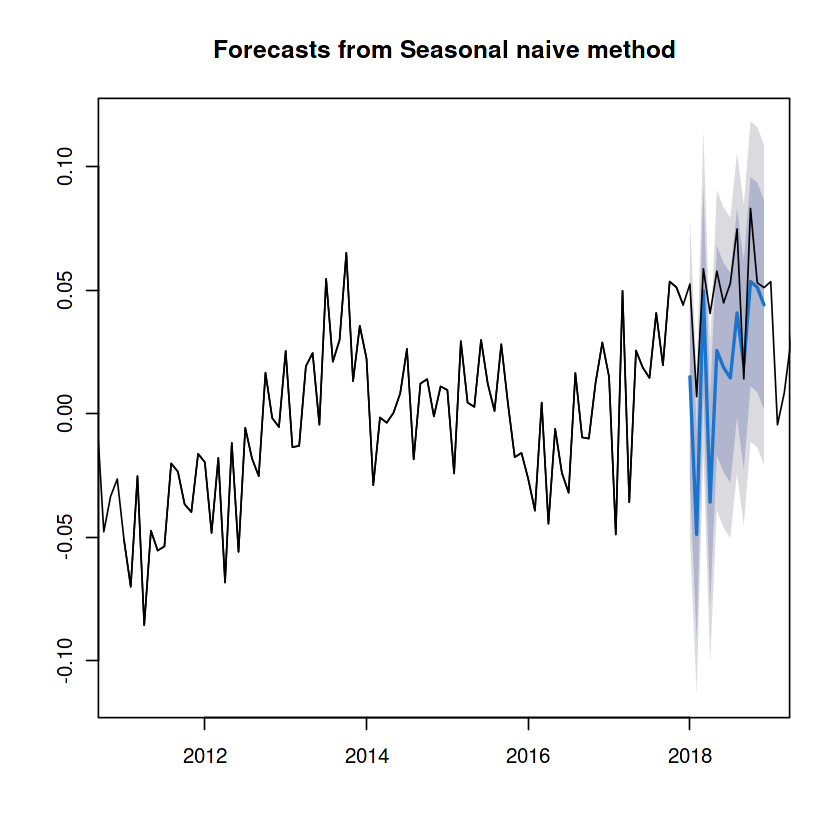

In [13]:
naive_estacional <- snaive(train, h = 12)
naive_estacional

# Testing the accuracy of the mean baseline forecast values against the actual values
accuracy(naive_estacional, test)

plot(naive_estacional, type = "l")
lines(log_serie)

#### Holt Winters

          Point Forecast        Lo 80      Hi 80         Lo 95      Hi 95
Jan 2018  0.033673170887  0.005470650 0.06187569 -0.0094588622 0.07680520
Feb 2018 -0.014404826262 -0.044218419 0.01540877 -0.0600007819 0.03119113
Mar 2018  0.075544967971  0.044203008 0.10688693  0.0276115760 0.12347836
Apr 2018  0.000009231505 -0.032789955 0.03280842 -0.0501527955 0.05017126
May 2018  0.058188456948  0.023994089 0.09238282  0.0058926843 0.11048423
Jun 2018  0.048750347008  0.013215534 0.08428516 -0.0055954599 0.10309615
Jul 2018  0.043684983396  0.006858483 0.08051148 -0.0126362881 0.10000625
Aug 2018  0.071132212498  0.033057821 0.10920660  0.0129024562 0.12936197
Sep 2018  0.051348242865  0.012065582 0.09063090 -0.0087294019 0.11142589
Oct 2018  0.074307282742  0.033852424 0.11476214  0.0124369159 0.13617765
Nov 2018  0.069216226181  0.027622191 0.11081026  0.0056036395 0.13282881
Dec 2018  0.064950125657  0.022247293 0.10765296 -0.0003582205 0.13025847

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.001550957,0.02190815,0.01722150,-50.486514,214.79392,0.6181162,-0.1594494,NA
Test set,0.001112809,0.01994610,0.01590627,9.651397,69.83225,0.5709097,-0.2220246,0.3013501


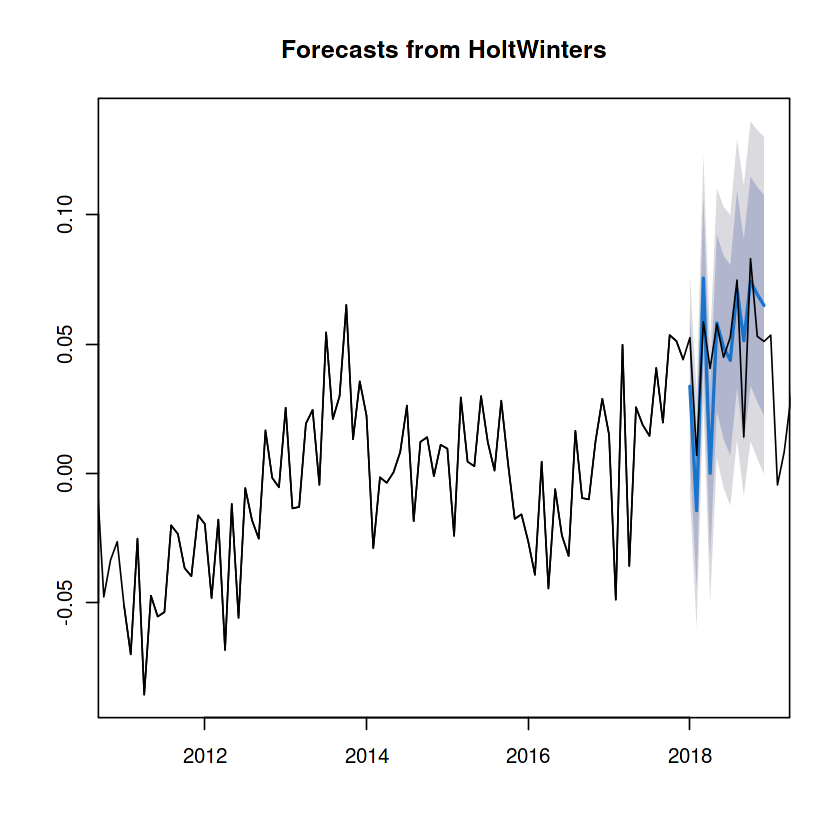

In [14]:
exphw <- HoltWinters(train)

expforecast <- forecast(exphw, h = 12)
expforecast

# Testing the accuracy of the mean baseline forecast values against the actual values
accuracy(expforecast, test)

plot(expforecast, type = "l")
lines(log_serie)

#### ARIMA

Series: train 
ARIMA(2,1,0)(1,0,0)[12] 

Coefficients:
          ar1      ar2    sar1
      -0.9002  -0.4736  0.4207
s.e.   0.1013   0.0964  0.1187

sigma^2 estimated as 0.0004011:  log likelihood=206.69
AIC=-405.37   AICc=-404.86   BIC=-395.7

         Point Forecast        Lo 80      Hi 80         Lo 95      Hi 95
Jan 2018     0.05637603  0.030708770 0.08204329  0.0171213423 0.09563072
Feb 2018     0.01977602 -0.006018803 0.04557085 -0.0196737595 0.05922580
Mar 2018     0.06141570  0.033292423 0.08953898  0.0184048589 0.10442654
Apr 2018     0.02989647 -0.001684313 0.06147725 -0.0184021701 0.07819511
May 2018     0.05161984  0.019177426 0.08406226  0.0020034473 0.10123624
Jun 2018     0.05030980  0.015657445 0.08496216 -0.0026864036 0.10330601
Jul 2018     0.04906066  0.012646857 0.08547446 -0.0066294456 0.10475076
Aug 2018     0.05890013  0.021183167 0.09661709  0.0012170125 0.11658325
Sep 2018     0.05086673  0.011429462 0.09030399 -0.0094473644 0.11118082
Oct 2018     0.06491010  0.024062320 0.10575787  0.0024388139 0.12738138
Nov 2018     0.06370050  0.021491815 0.10590918 -0.0008521131 0.12825311
Dec 2018     0.06100243  0.017369527 0.10463532 -0.0057283343 0.12773319

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.002025592,0.01954559,0.01561916,12.73894,128.56869,0.5606047,0.02316903,NA
Test set,-0.002340023,0.01452335,0.01141267,-35.40565,49.88733,0.4096250,-0.50720305,0.1689836


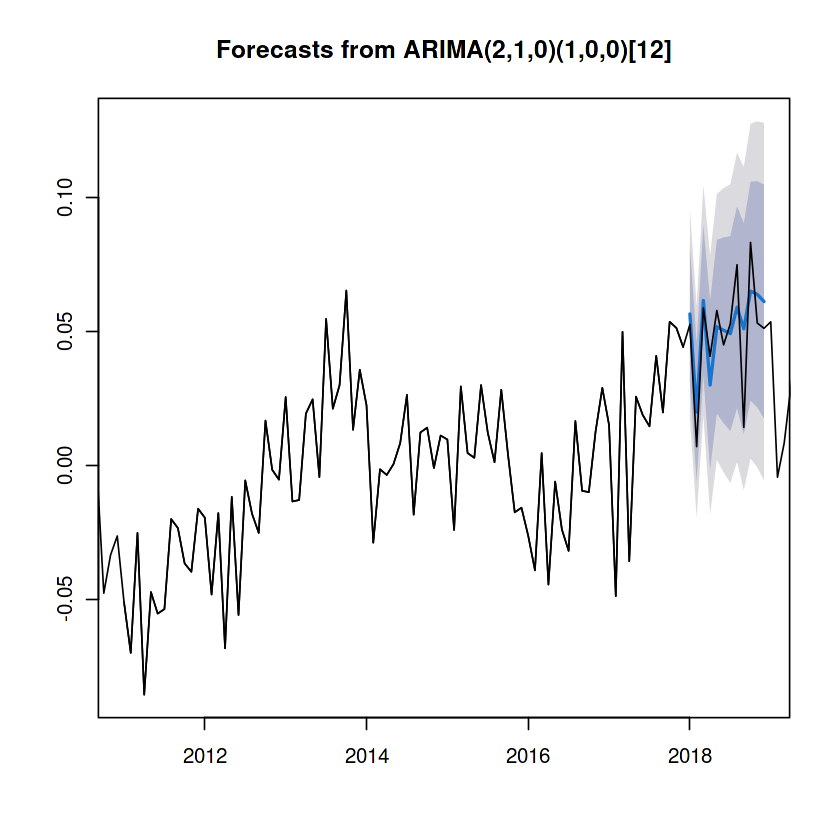

In [15]:
autoArimaFit <- auto.arima(train)
autoArimaFit # ARIMA(2,1,0)(1,0,0)[12] 

Arimaforecast <- forecast(autoArimaFit, h = 12)
Arimaforecast

accuracy(Arimaforecast, test)

plot(Arimaforecast)
lines(log_serie)

### Analisis de los Residuos

#### Simple Average


	Augmented Dickey-Fuller Test

data:  simple_average$residuals
Dickey-Fuller = -2.0171, Lag order = 12, p-value = 0.5688
alternative hypothesis: stationary


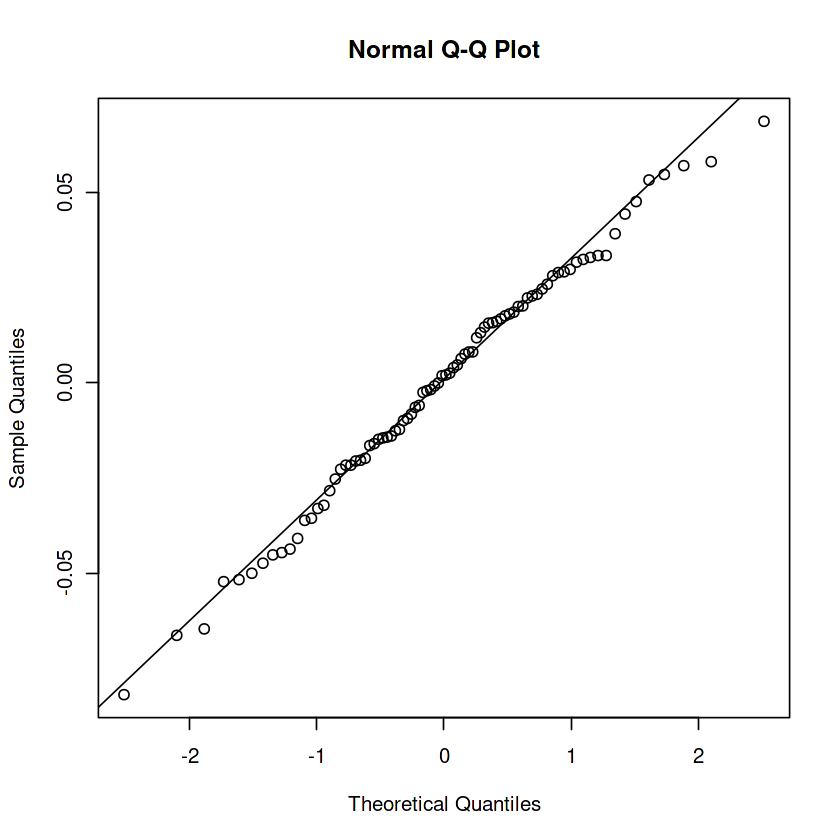


	Ljung-Box test

data:  Residuals from Mean
Q* = 119.23, df = 16, p-value < 0.00000000000000022

Model df: 1.   Total lags used: 17

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n   miss                       mean                         sd                        min                        mdn                        max 
     84      0            -0.000000000000             0.031475120628            -0.081983320229             0.001998044417             0.068790083540 


,P_Value,Statistic
,<dbl>,<dbl>
X-squared,0.5975852,1.029717


,P_Value,Statistic
,<dbl>,<dbl>
A,0.7739398,0.2386828


,P_Value,Statistic
,<dbl>,<dbl>
W,0.818835,0.9907543


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.081983 -0.020393  0.001998  0.000000  0.022480  0.068790 

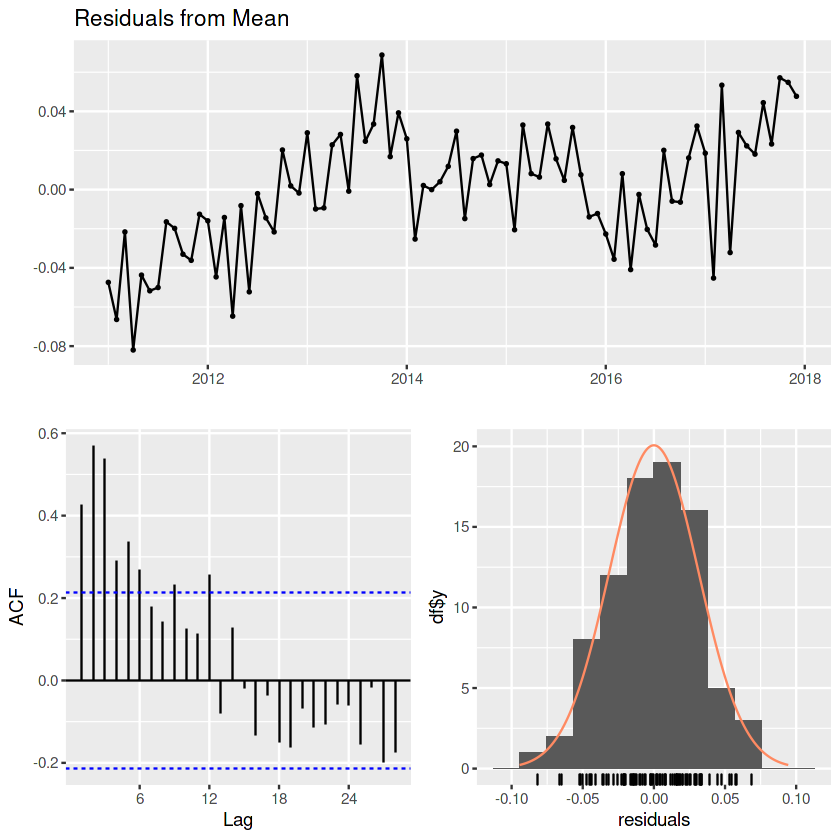

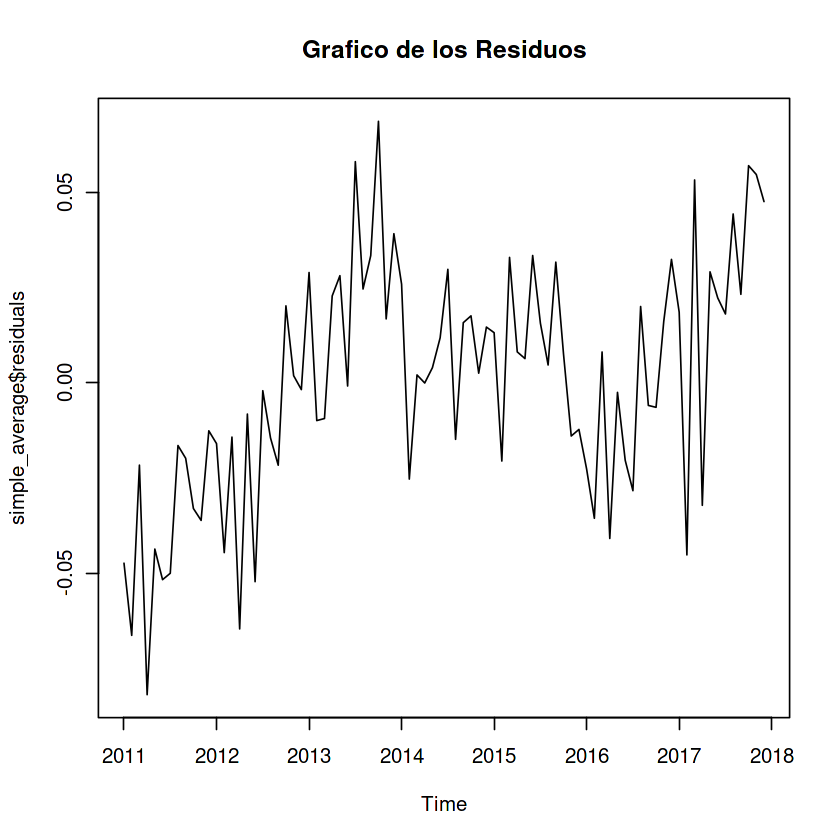

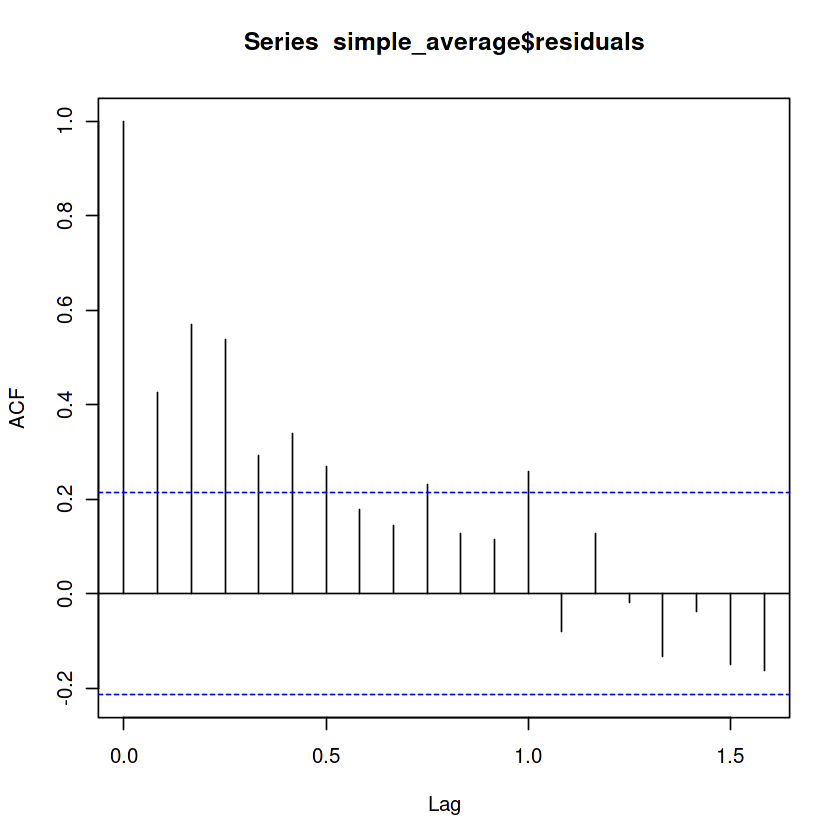

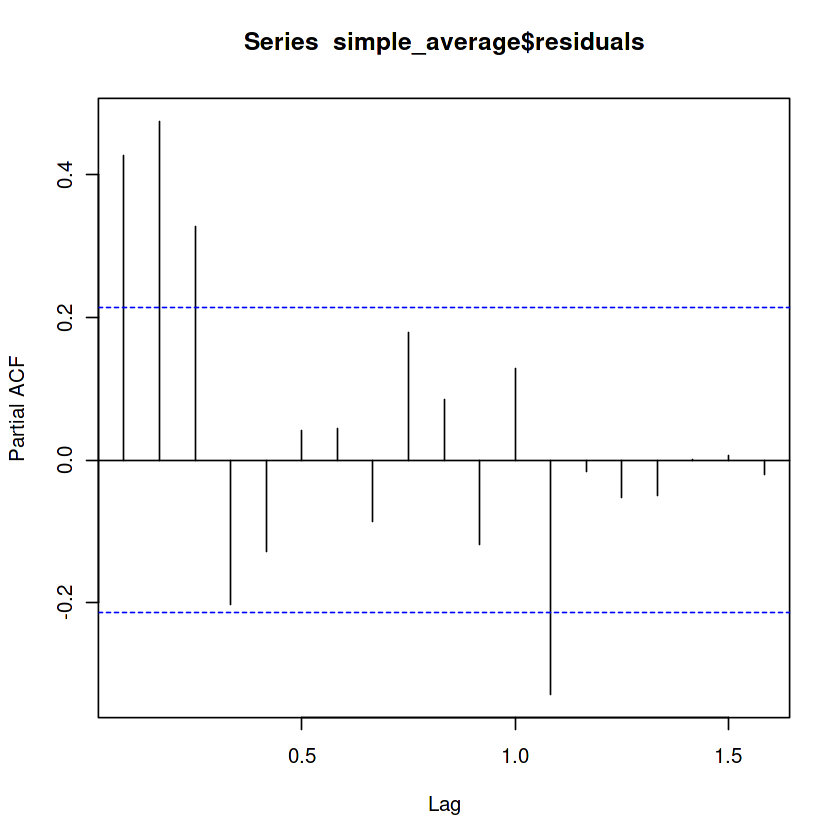

j,P_Value,Statistic
<int>,<dbl>,<dbl>
1,0.0000684652139789632130,15.85280
2,0.0000000002121707254332,44.54726
3,0.0000000000000035527137,70.34204
4,0.0000000000000004440892,78.01677
5,0.0000000000000000000000,88.46906
6,0.0000000000000000000000,95.15973
7,0.0000000000000000000000,98.15871
8,0.0000000000000000000000,100.11483
9,0.0000000000000000000000,105.28539


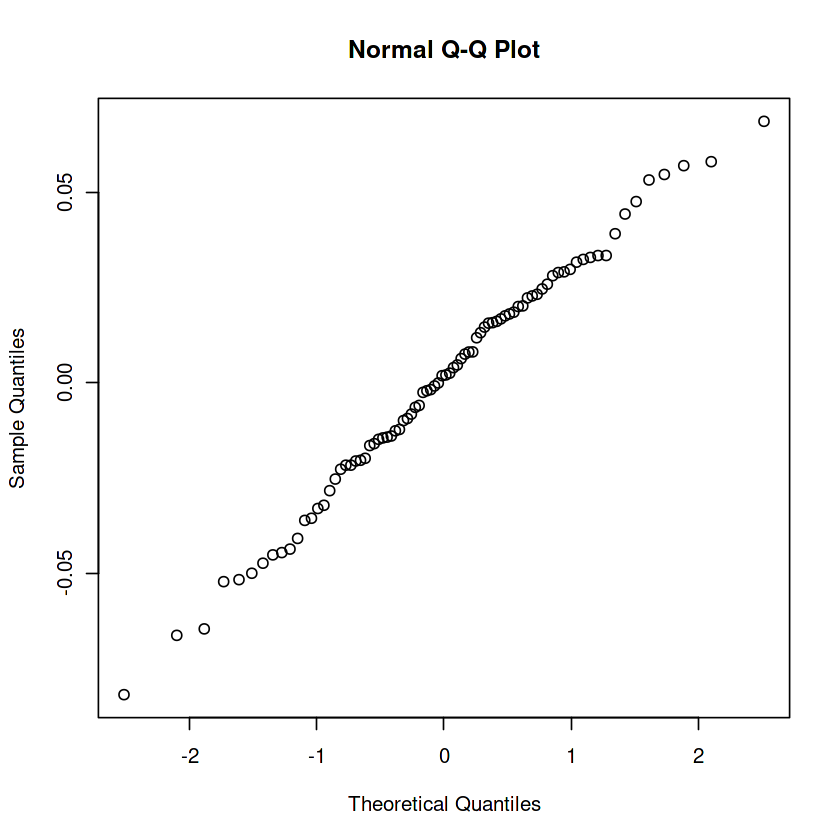

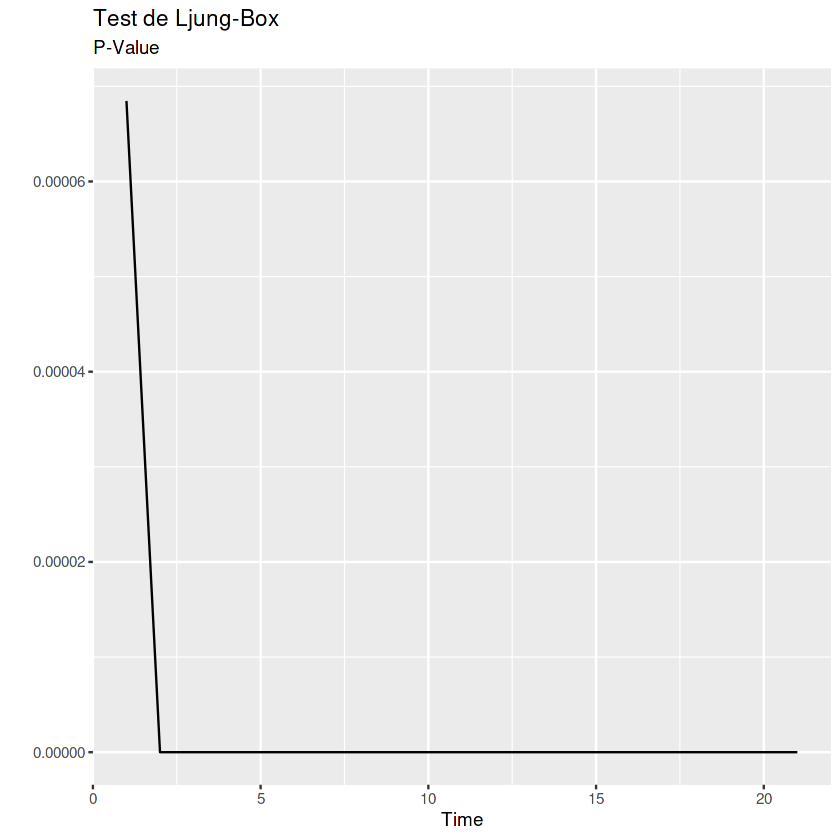

In [16]:
qqnorm(residuals(simple_average))
qqline(residuals(simple_average))

adf.test(simple_average$residuals, alternative = "stationary", k = 12)

checkresiduals(simple_average)

# Otra forma
residuos <- resid(simple_average)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)

# Gr?ficos de los residuos, ACF, PACF y qq norm
plot(simple_average$residuals, main = "Grafico de los Residuos")
acf(simple_average$residuals, na.action = na.pass)
pacf(simple_average$residuals, na.action = na.pass)
qqnorm(simple_average$residuals)

# Testeo de Incorrelaci?n de los Residuos

Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

#### Naive Bayes


	Augmented Dickey-Fuller Test

data:  na.omit(naive_ingenuo$residuals)
Dickey-Fuller = -1.9497, Lag order = 12, p-value = 0.5965
alternative hypothesis: stationary


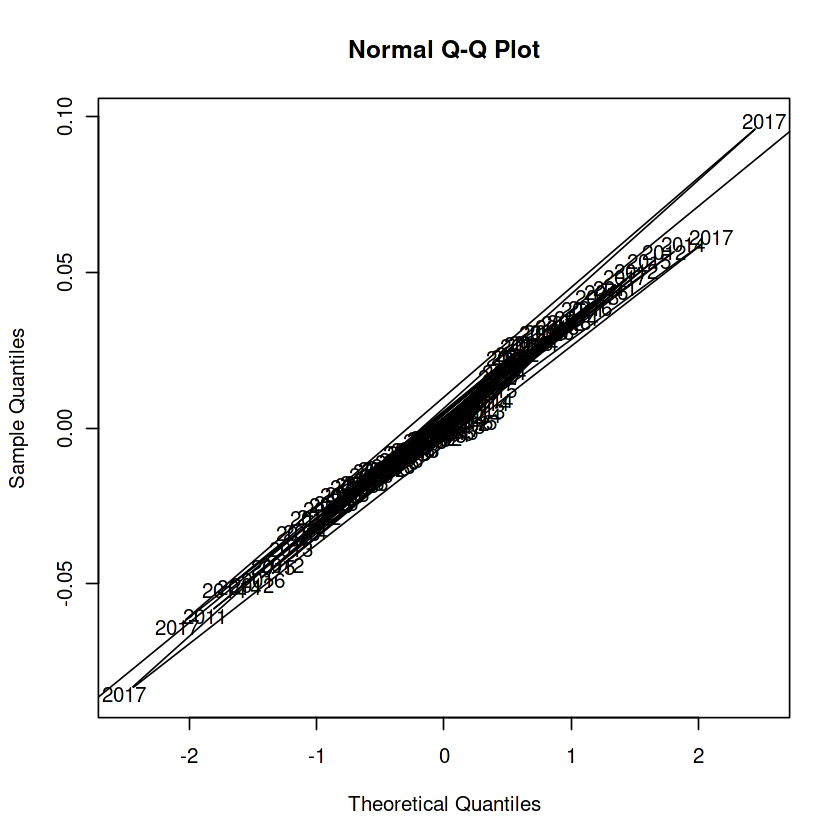


	Ljung-Box test

data:  Residuals from Random walk
Q* = 122.05, df = 17, p-value < 0.00000000000000022

Model df: 0.   Total lags used: 17

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n   miss                     mean                       sd                      min                      mdn                      max 
     83      1            0.00114576084            0.03306263577           -0.08554891817           -0.00231968216            0.09859066750 


,P_Value,Statistic
,<dbl>,<dbl>
X-squared,0.9143496,0.1790846


,P_Value,Statistic
,<dbl>,<dbl>
A,0.3034396,0.4287539


,P_Value,Statistic
,<dbl>,<dbl>
W,0.7310336,0.989323


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
-0.085549 -0.018104 -0.002320  0.001146  0.027068  0.098591         1 

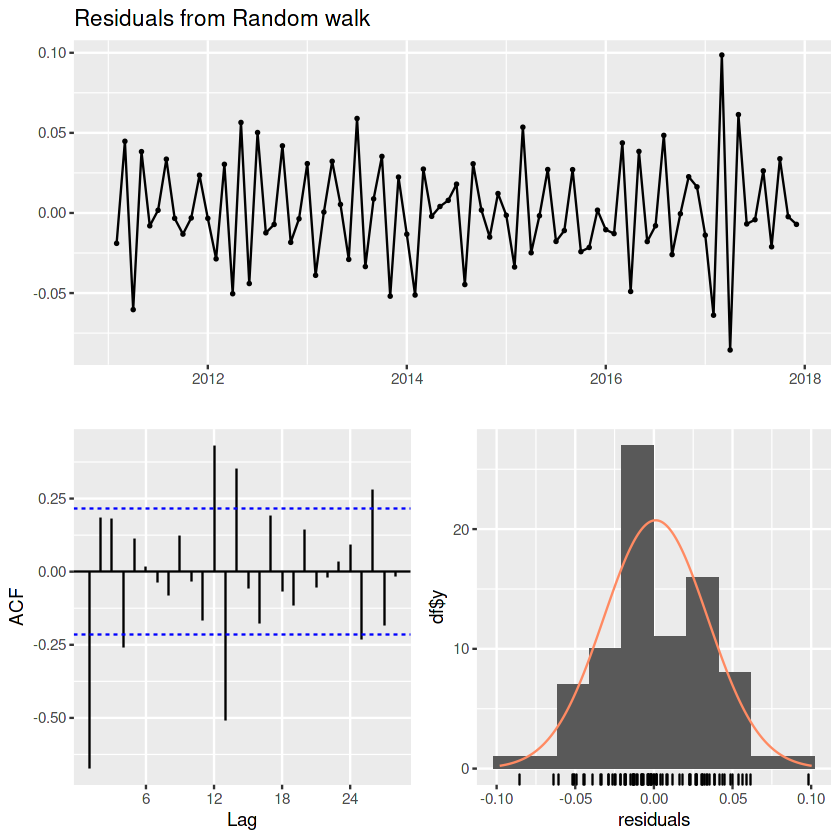

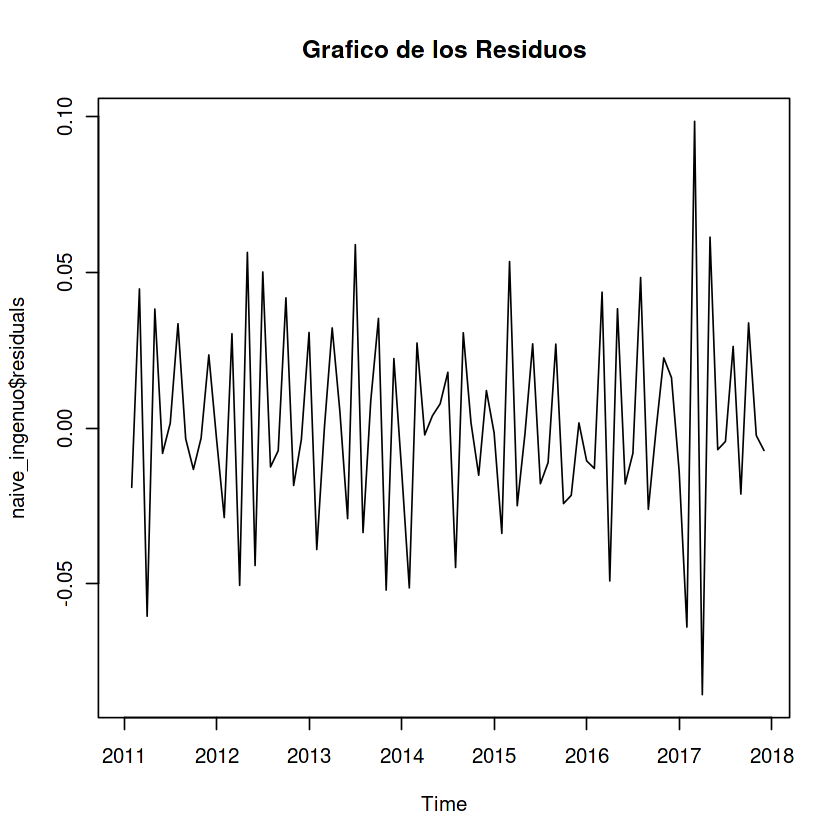

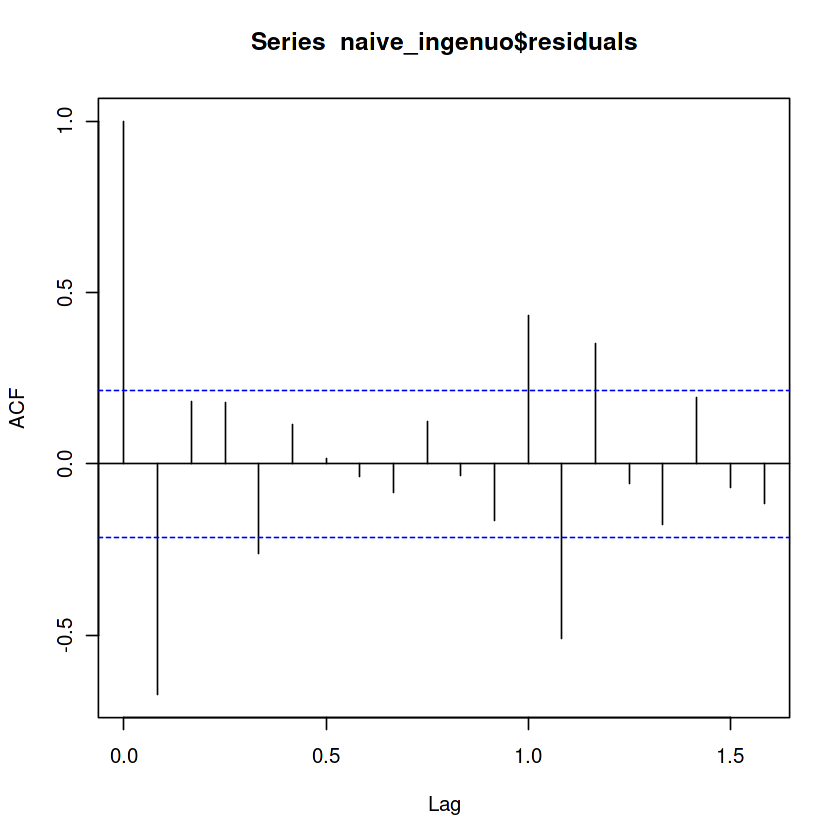

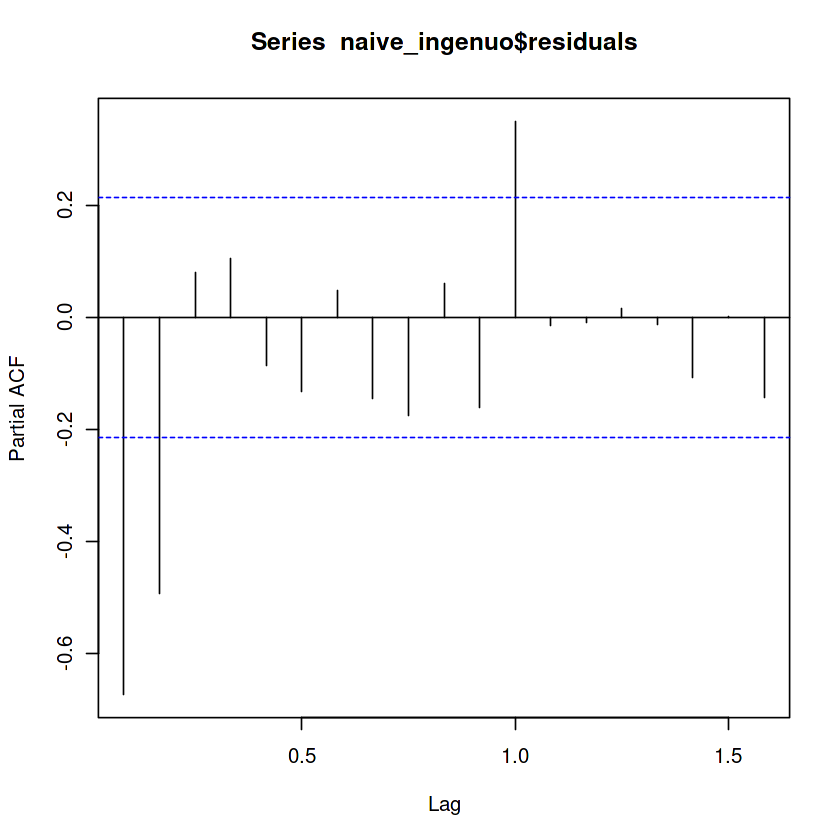

j,P_Value,Statistic
<int>,<dbl>,<dbl>
1,0.0000000004242820539346,38.99781
2,0.0000000007834271009699,41.93469
3,0.0000000010181185894353,44.80458
4,0.0000000002367285256710,50.87789
5,0.0000000005206518549628,52.07521
6,0.0000000017800529938938,52.10046
7,0.0000000052704307584861,52.22554
8,0.0000000114547865637249,52.86468
9,0.0000000164218345588552,54.31835


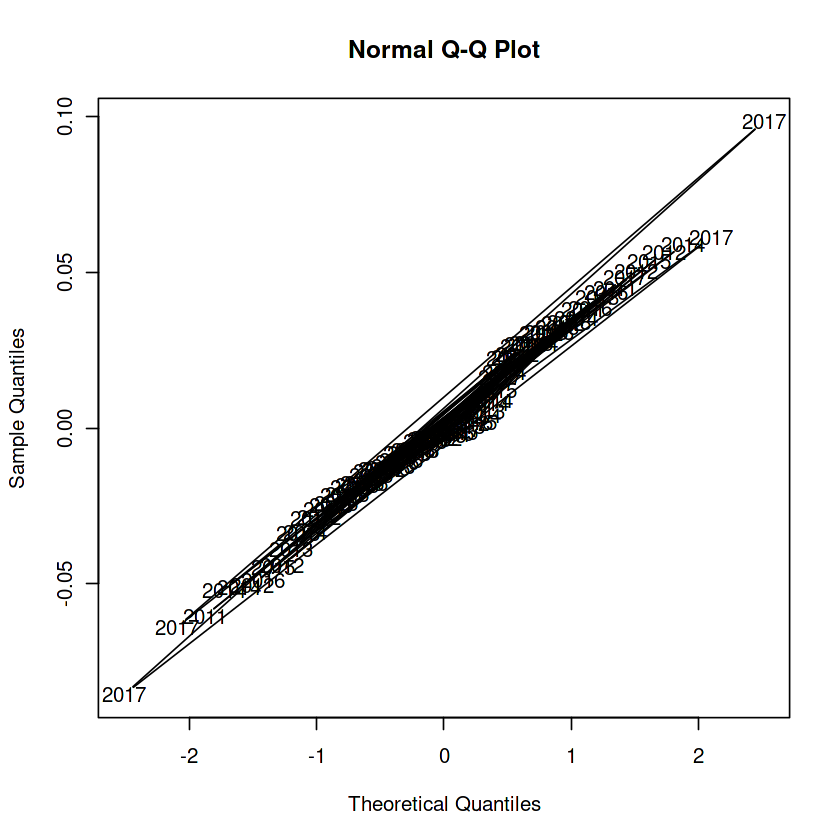

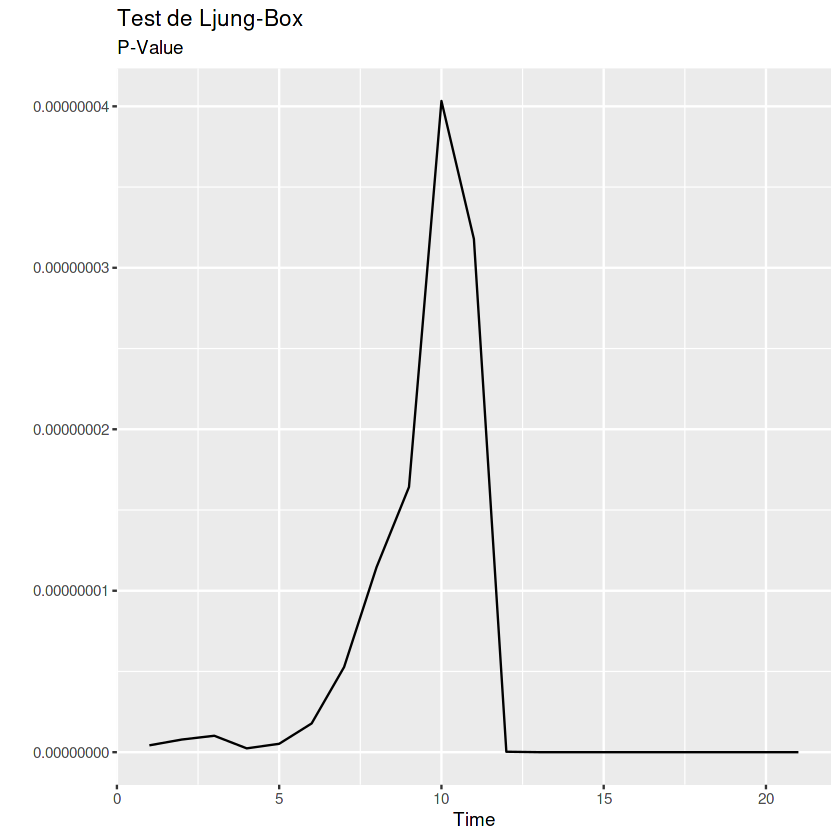

In [17]:
qqnorm(residuals(naive_ingenuo))
qqline(residuals(naive_ingenuo))

adf.test(na.omit(naive_ingenuo$residuals), alternative = "stationary", k = 12)

checkresiduals(naive_ingenuo)

# Otra forma
residuos <- resid(naive_ingenuo)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)


# Gr?ficos de los residuos, ACF, PACF y qq norm
plot(naive_ingenuo$residuals, main = "Grafico de los Residuos")
acf(naive_ingenuo$residuals, na.action = na.pass)
pacf(naive_ingenuo$residuals, na.action = na.pass)
qqnorm(naive_ingenuo$residuals)

# Testeo de Incorrelaci?n de los Residuos
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

#### Naive Estacional


	Augmented Dickey-Fuller Test

data:  na.omit(naive_estacional$residuals)
Dickey-Fuller = -1.8116, Lag order = 4, p-value = 0.6521
alternative hypothesis: stationary


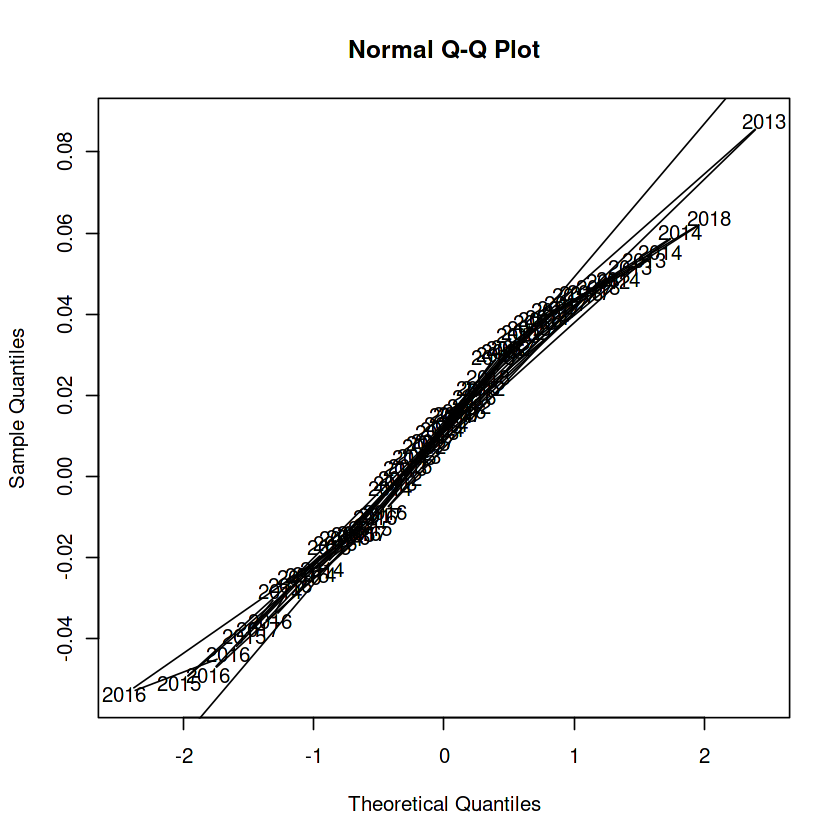


	Ljung-Box test

data:  Residuals from Seasonal naive method
Q* = 122.7, df = 17, p-value < 0.00000000000000022

Model df: 0.   Total lags used: 17

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n    miss                     mean                       sd                      min                      mdn                      max 
     72      12            0.01073032579            0.03152312570           -0.05384719884            0.01206734517            0.08756005027 


,P_Value,Statistic
,<dbl>,<dbl>
X-squared,0.4650646,1.531158


,P_Value,Statistic
,<dbl>,<dbl>
A,0.2713802,0.4482017


,P_Value,Statistic
,<dbl>,<dbl>
W,0.3635669,0.9813624


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
-0.05385 -0.01418  0.01207  0.01073  0.03681  0.08756       12 

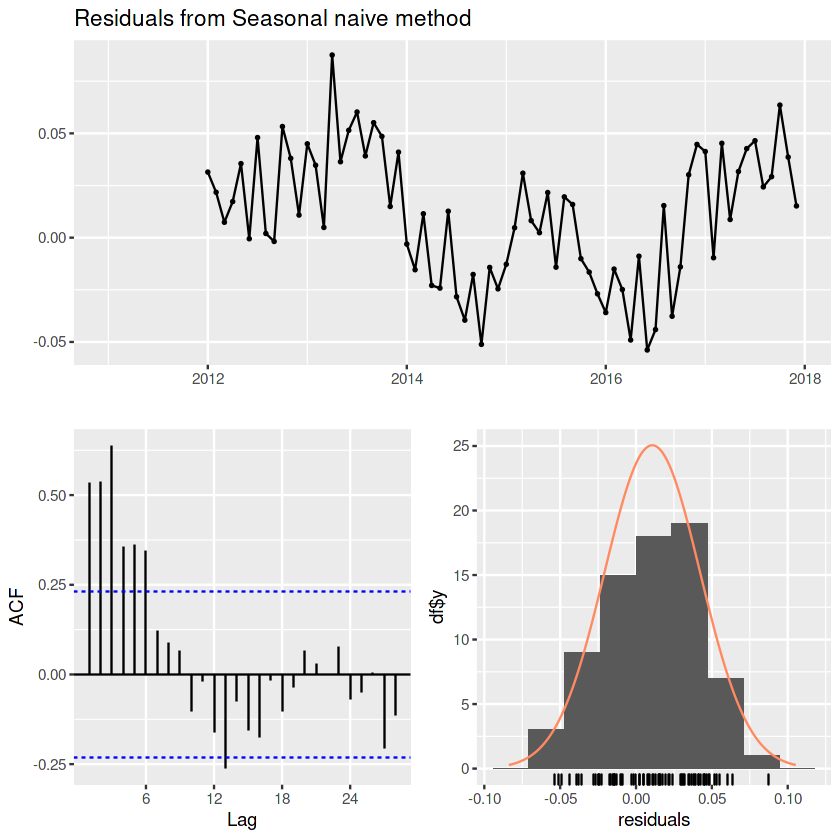

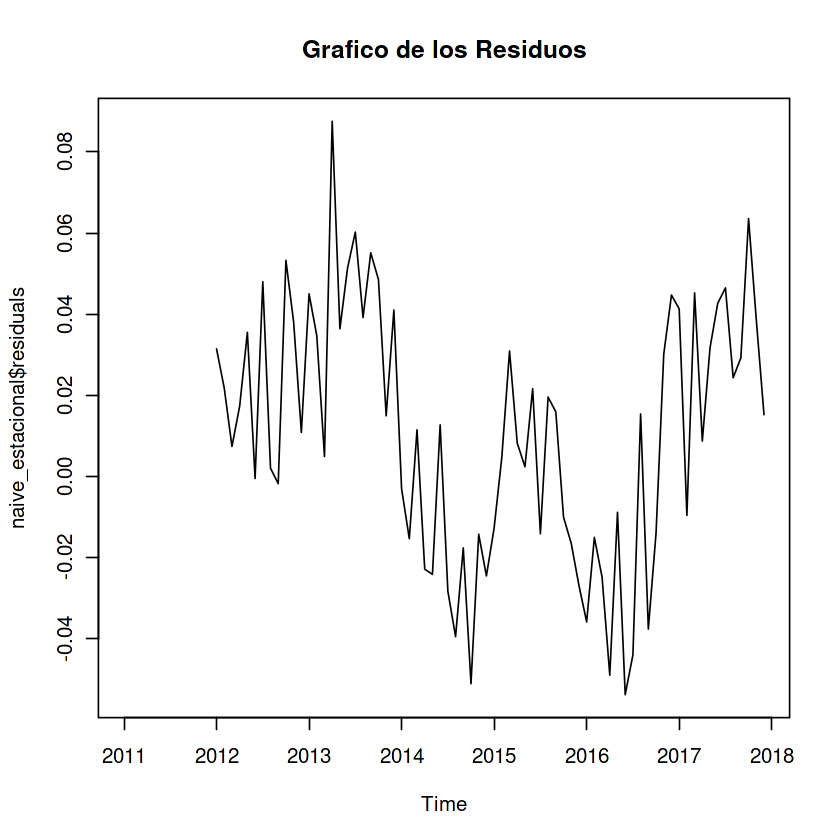

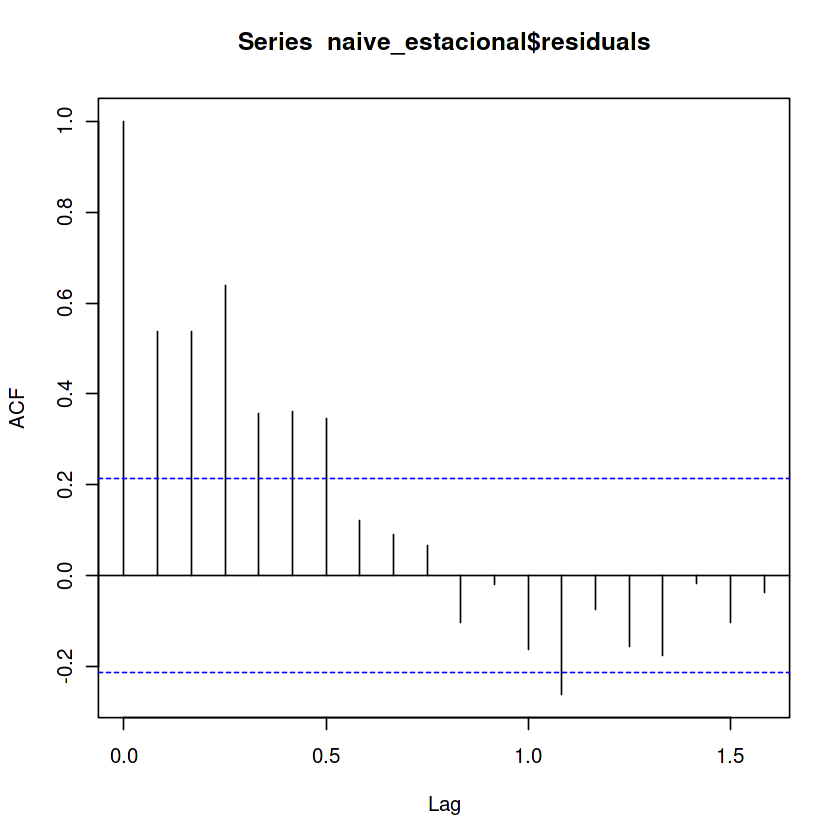

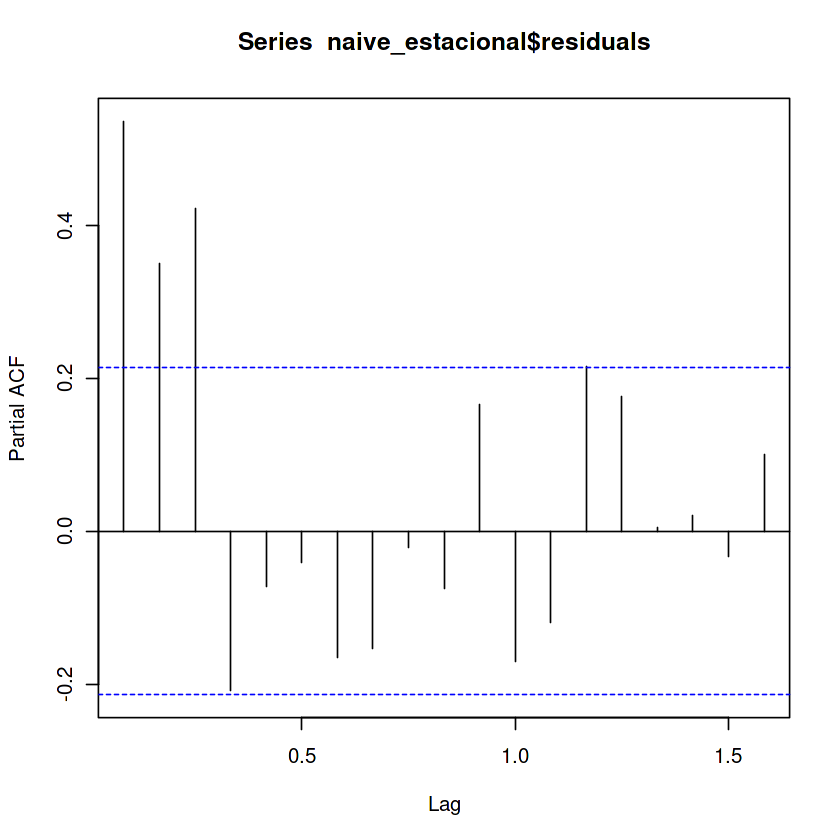

j,P_Value,Statistic
<int>,<dbl>,<dbl>
1,0.0000033892903905652361,21.58251
2,0.0000000003547442339880,43.51925
3,0.0000000000000003330669,75.03354
4,0.0000000000000000000000,84.98511
5,0.0000000000000000000000,95.35644
6,0.0000000000000000000000,105.04946
7,0.0000000000000000000000,106.27364
8,0.0000000000000000000000,106.95006
9,0.0000000000000000000000,107.31893


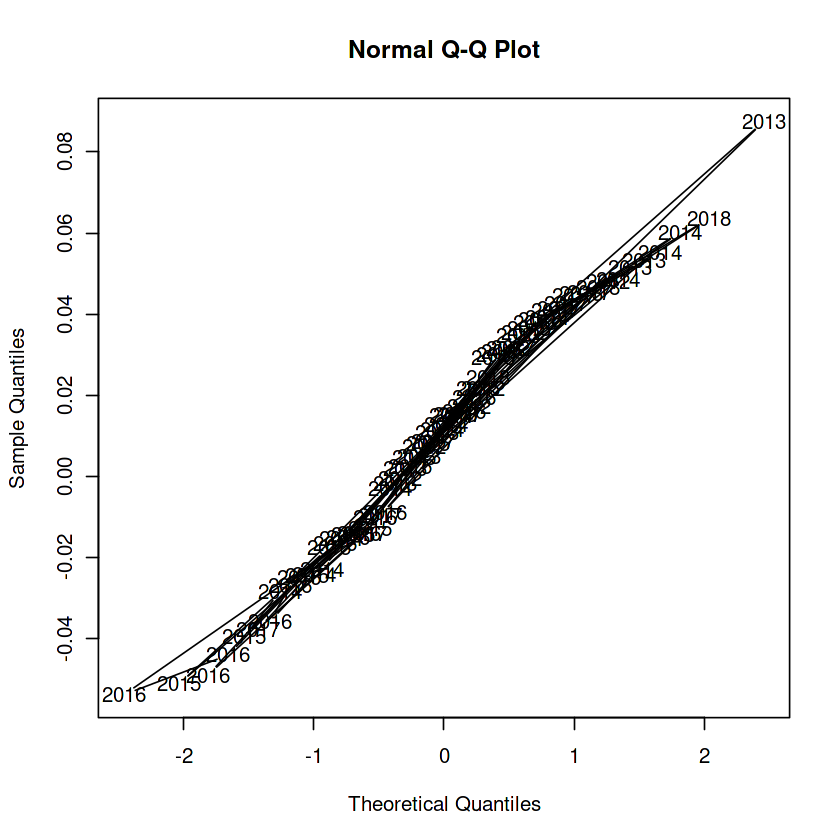

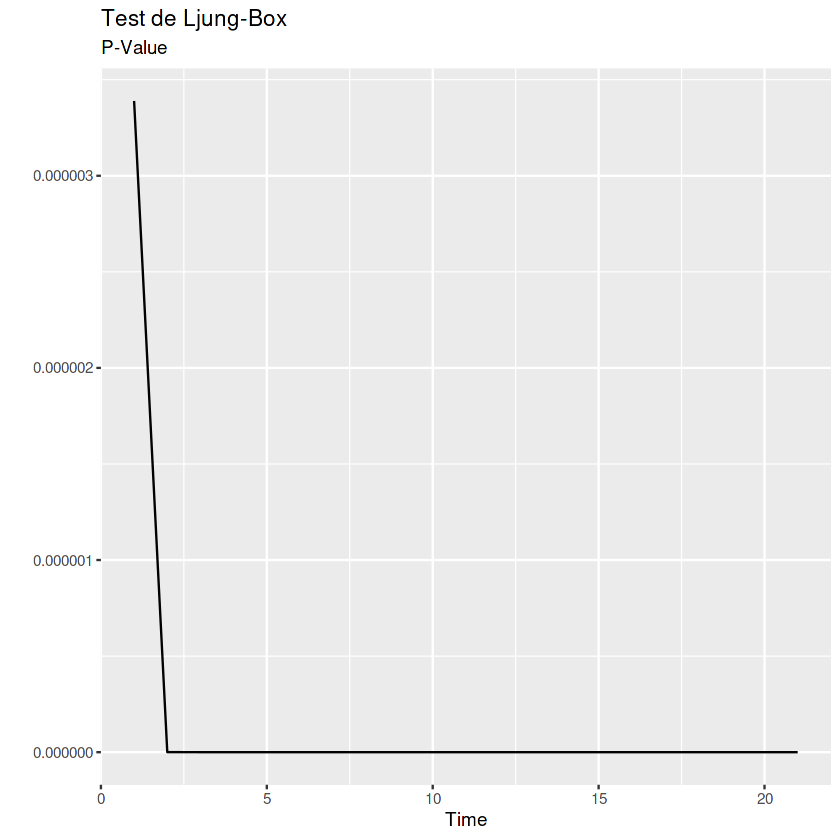

In [18]:
qqnorm(residuals(naive_estacional))
qqline(residuals(naive_estacional))

adf.test(na.omit(naive_estacional$residuals), alternative = "stationary")

checkresiduals(naive_estacional)

# Otra forma
residuos <- resid(naive_estacional)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)

# Gr?ficos de los residuos, ACF, PACF y qq norm
plot(naive_estacional$residuals, main = "Grafico de los Residuos")
acf(naive_estacional$residuals, na.action = na.pass)
pacf(naive_estacional$residuals, na.action = na.pass)
qqnorm(naive_estacional$residuals)

# Testeo de Incorrelaci?n de los Residuos
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

#### Holt Winters


	Augmented Dickey-Fuller Test

data:  na.omit(expforecast$residuals)
Dickey-Fuller = -2.4913, Lag order = 12, p-value = 0.3753
alternative hypothesis: stationary


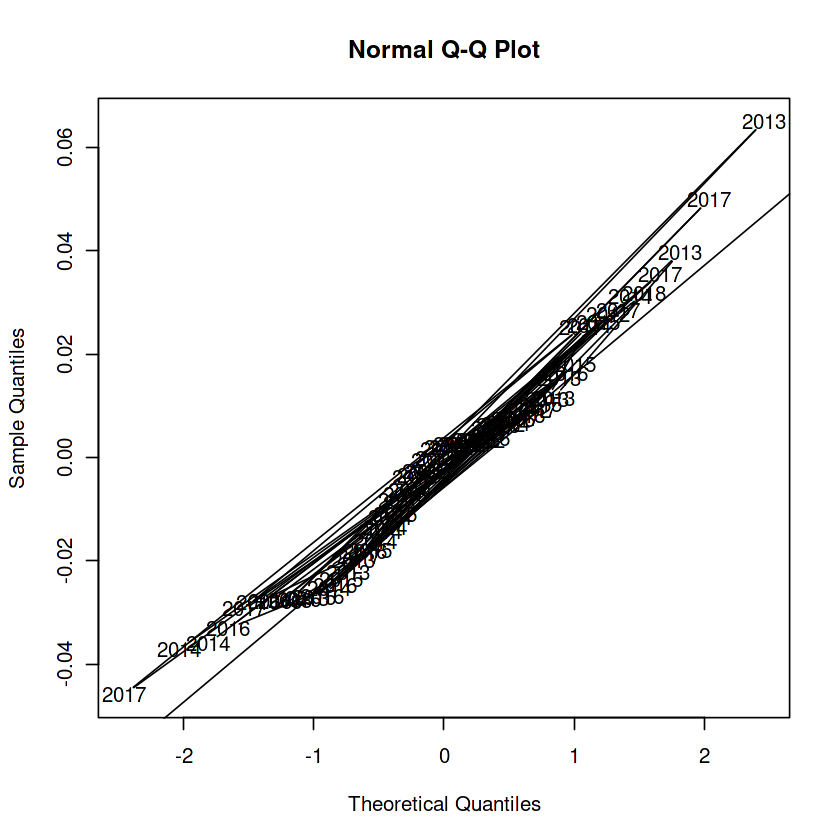

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n    miss                      mean                        sd                       min                       mdn                       max 
     72      12            -0.00155095742             0.02200654372            -0.04593705948             0.00171361111             0.06511575978 


,P_Value,Statistic
,<dbl>,<dbl>
X-squared,0.3141041,2.316062


,P_Value,Statistic
,<dbl>,<dbl>
A,0.08043674,0.6623388


,P_Value,Statistic
,<dbl>,<dbl>
W,0.107033,0.9719101


     Min.   1st Qu.    Median      Mean   3rd Qu.      Max.      NA's 
-0.045937 -0.019330  0.001714 -0.001551  0.009176  0.065116        12 

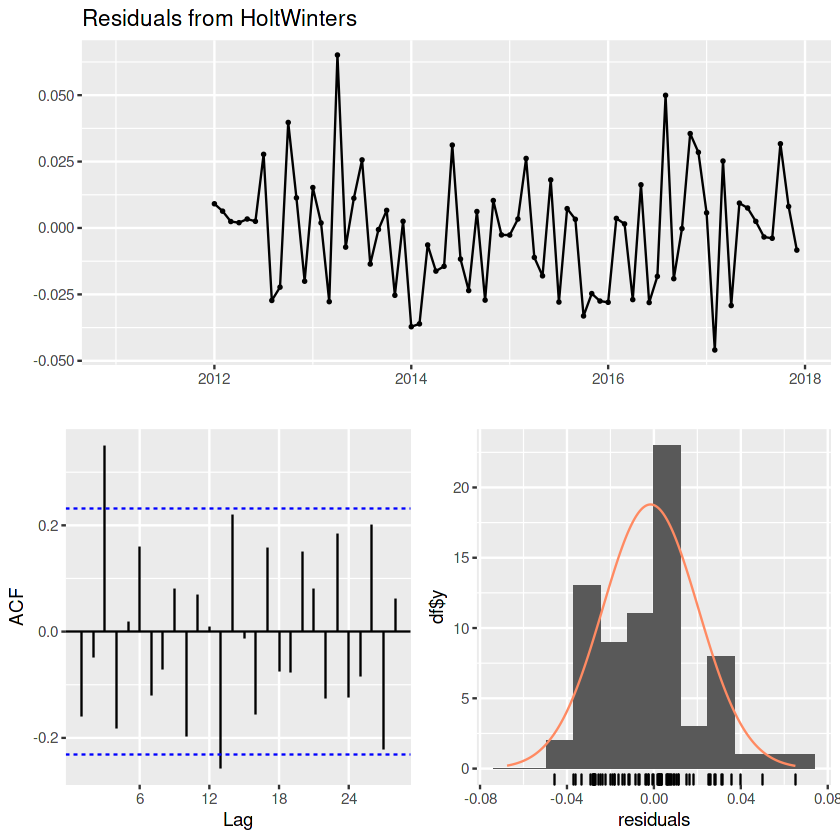

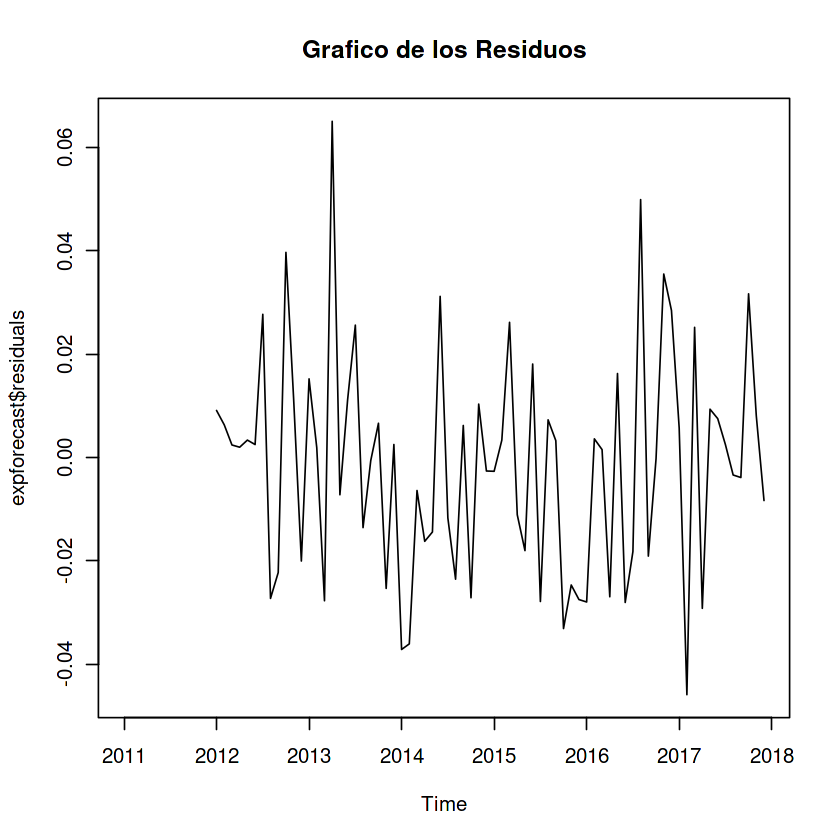

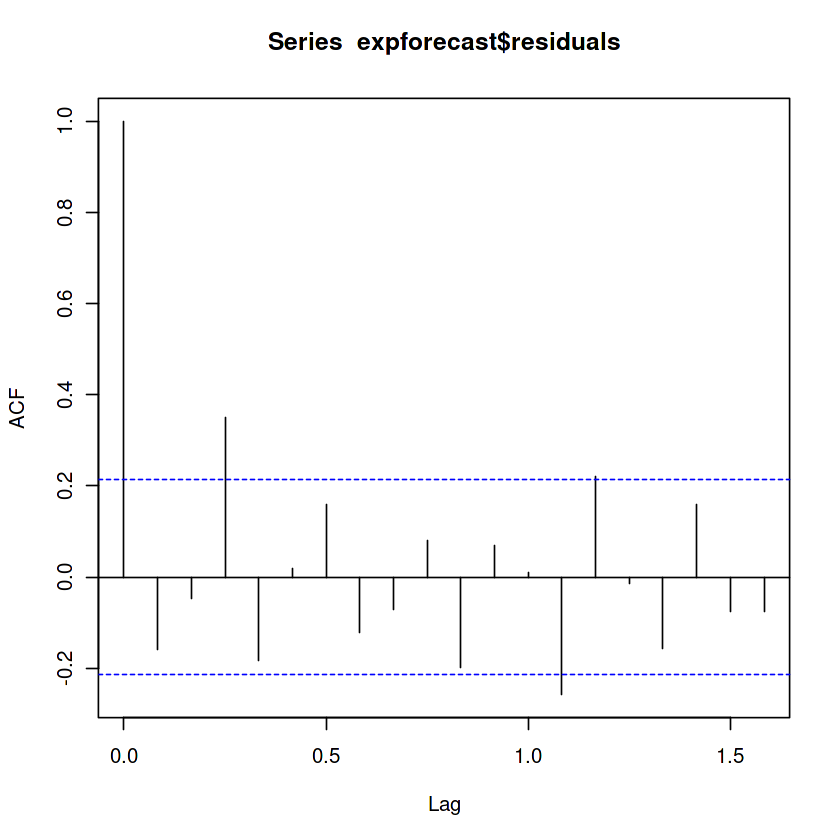

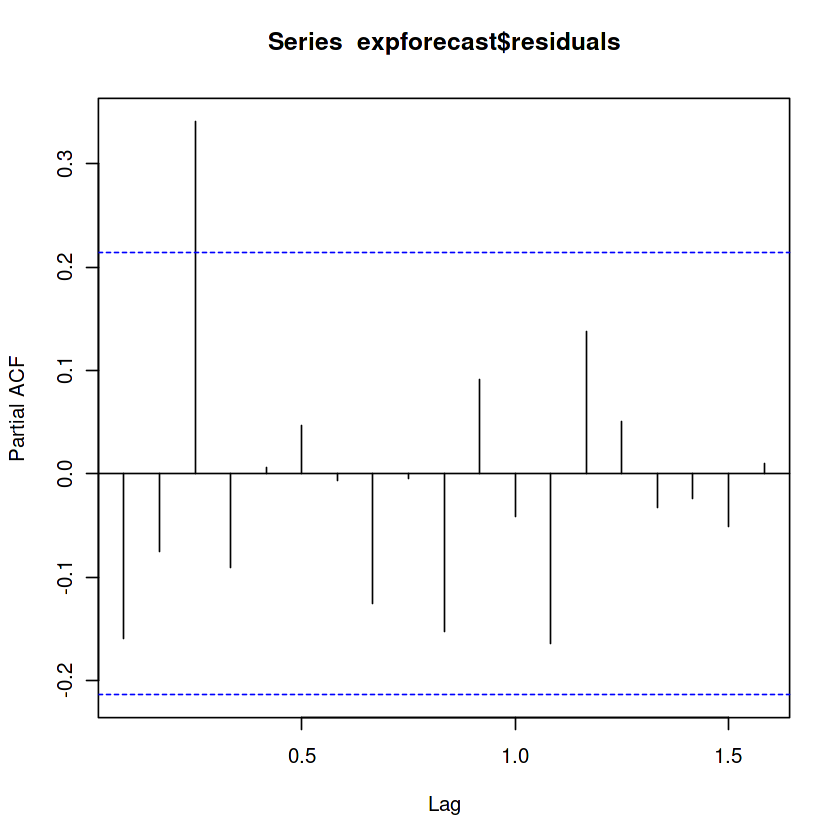

j,P_Value,Statistic
<int>,<dbl>,<dbl>
1,0.167198720,1.907882
2,0.353126231,2.081859
3,0.008985960,11.576048
4,0.006735332,14.182321
5,0.014326772,14.210395
6,0.012396673,16.265709
7,0.014662504,17.459373
8,0.022163084,17.877601
9,0.030465209,18.433435


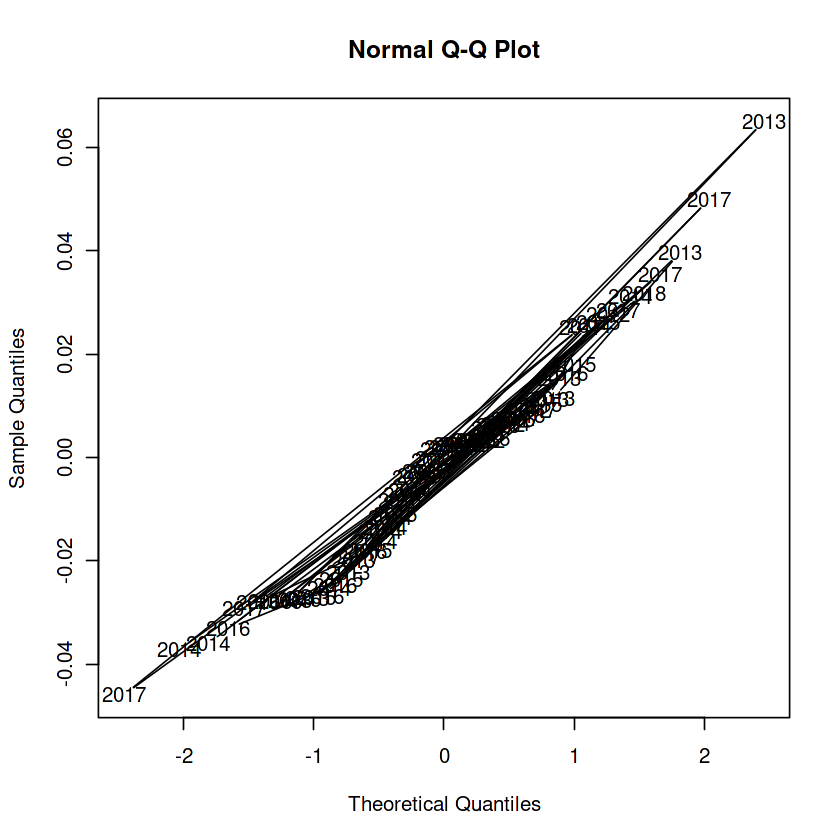

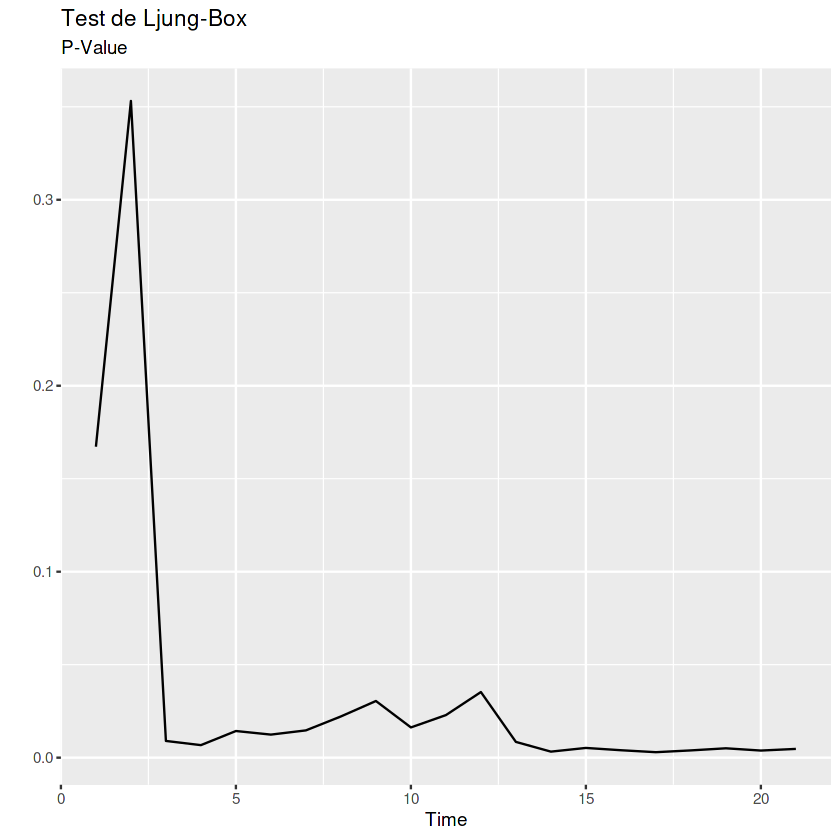

In [19]:
qqnorm(residuals(expforecast))
qqline(residuals(expforecast))

adf.test(na.omit(expforecast$residuals), alternative = "stationary", k = 12)

checkresiduals(expforecast)

# Otra forma
residuos <- resid(expforecast)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)

# Gr?ficos de los residuos, ACF, PACF y qq norm
plot(expforecast$residuals, main = "Grafico de los Residuos")
acf(expforecast$residuals, na.action = na.pass)
pacf(expforecast$residuals, na.action = na.pass)
qqnorm(expforecast$residuals)

# Testeo de Incorrelaci?n de los Residuos
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")

#### ARIMA


	Augmented Dickey-Fuller Test

data:  Arimaforecast$residuals
Dickey-Fuller = -3.6622, Lag order = 4, p-value = 0.03298
alternative hypothesis: stationary


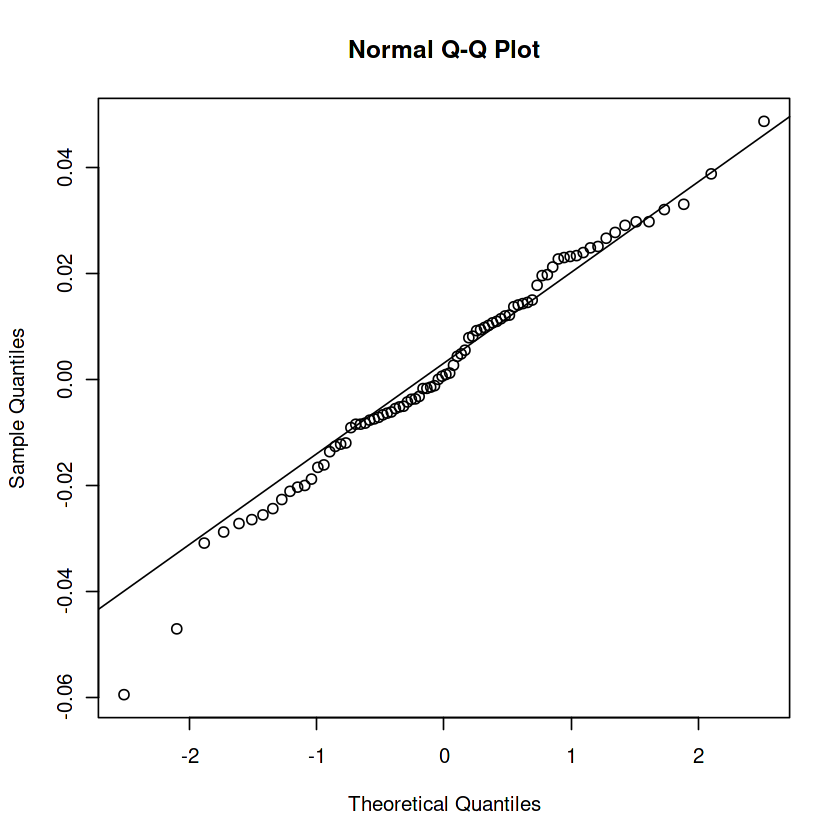


	Ljung-Box test

data:  Residuals from ARIMA(2,1,0)(1,0,0)[12]
Q* = 14.286, df = 14, p-value = 0.4286

Model df: 3.   Total lags used: 17

>>> Note: residuos is from the workspace, not in a data frame (table)




--- residuos --- 
 
     n   miss                      mean                        sd                       min                       mdn                       max 
     84      0            0.002025591990            0.019557107280           -0.059557073076            0.000709198275            0.048650825488 


,P_Value,Statistic
,<dbl>,<dbl>
X-squared,0.4372888,1.654323


,P_Value,Statistic
,<dbl>,<dbl>
A,0.6301157,0.2818214


,P_Value,Statistic
,<dbl>,<dbl>
W,0.5630527,0.9869795


      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.0595571 -0.0085089  0.0007092  0.0020256  0.0145805  0.0486508 

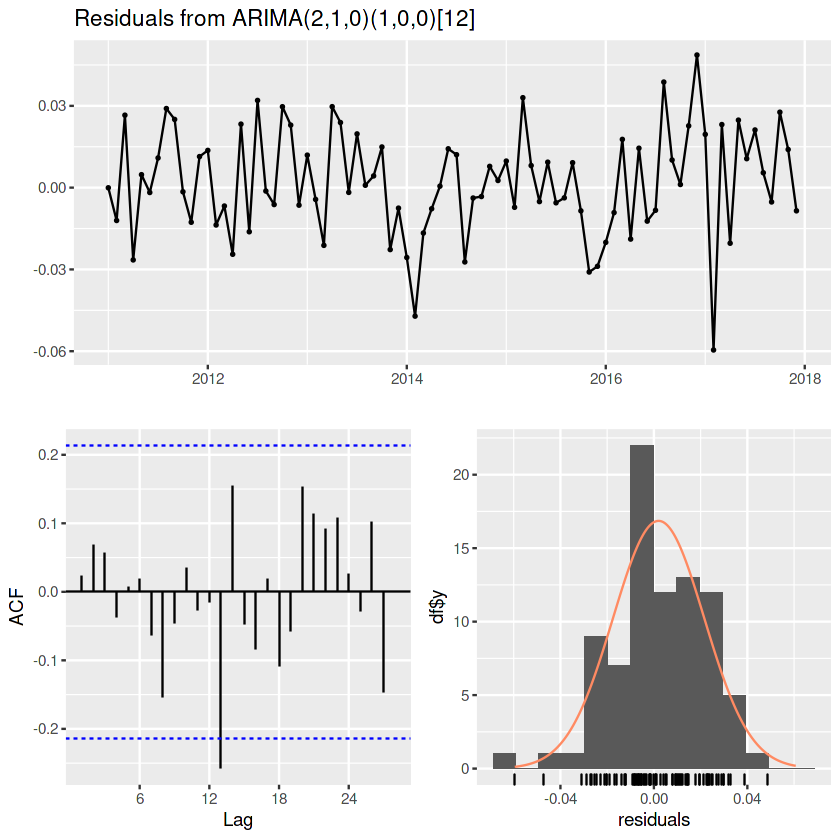

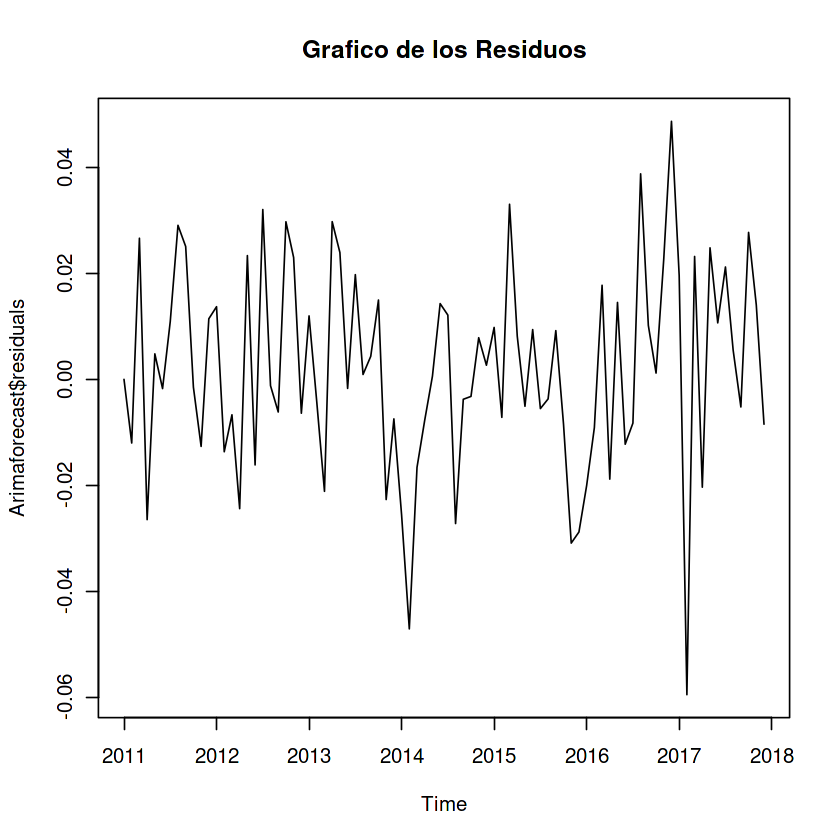

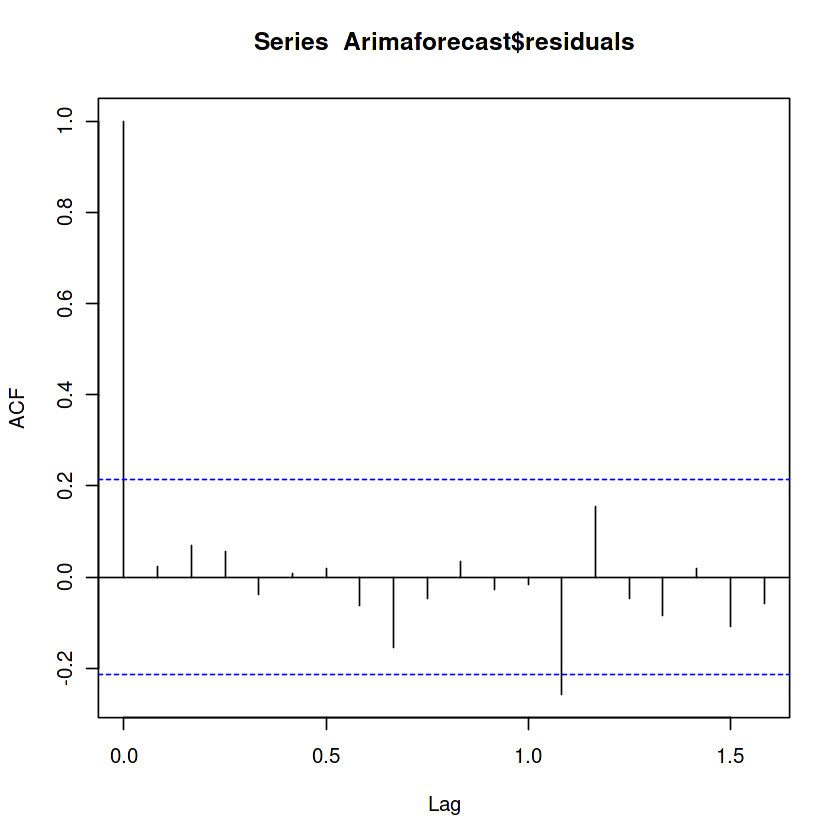

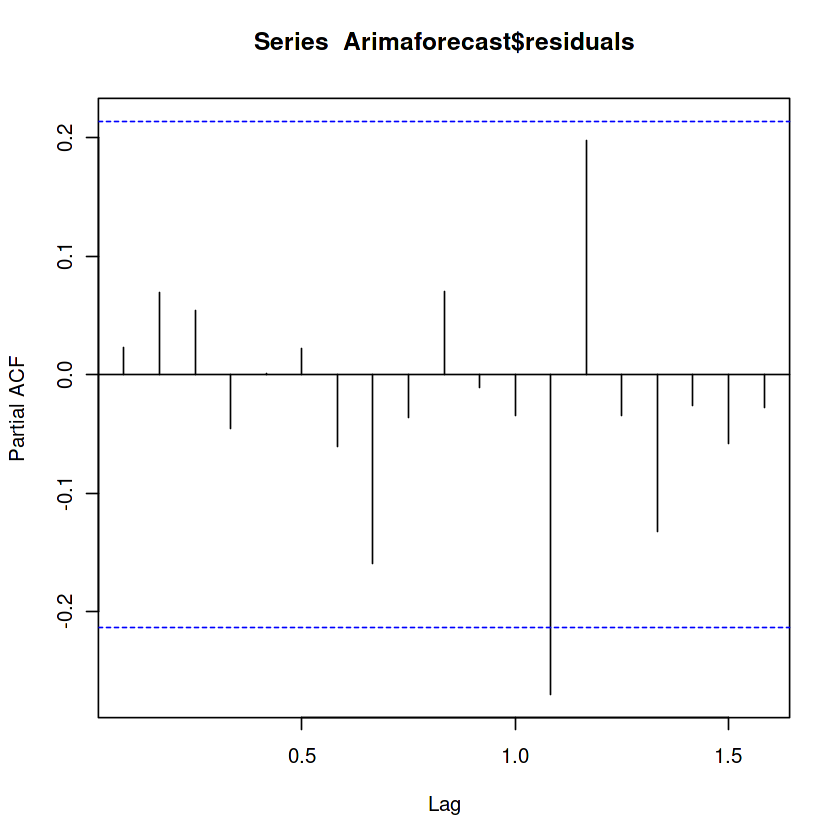

j,P_Value,Statistic
<int>,<dbl>,<dbl>
1,0.8288699,0.04672134
2,0.7895507,0.47258253
3,0.8590753,0.75971954
4,0.9258913,0.89069951
5,0.9705603,0.89530978
6,0.9881561,0.92914741
7,0.9883391,1.30373486
8,0.8930109,3.57852094
9,0.9246812,3.79002235


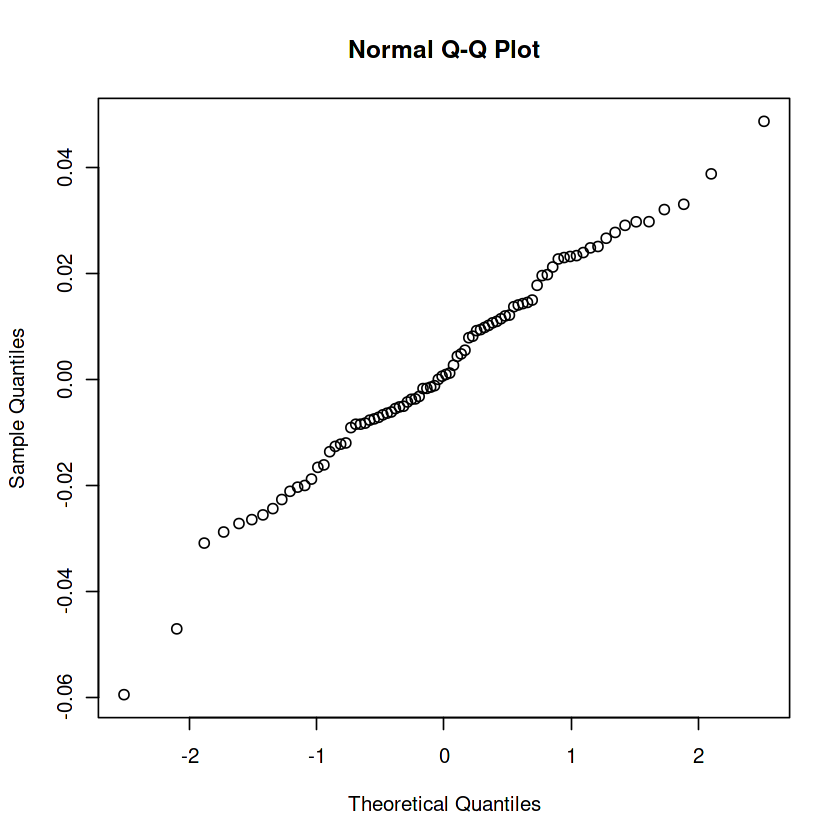

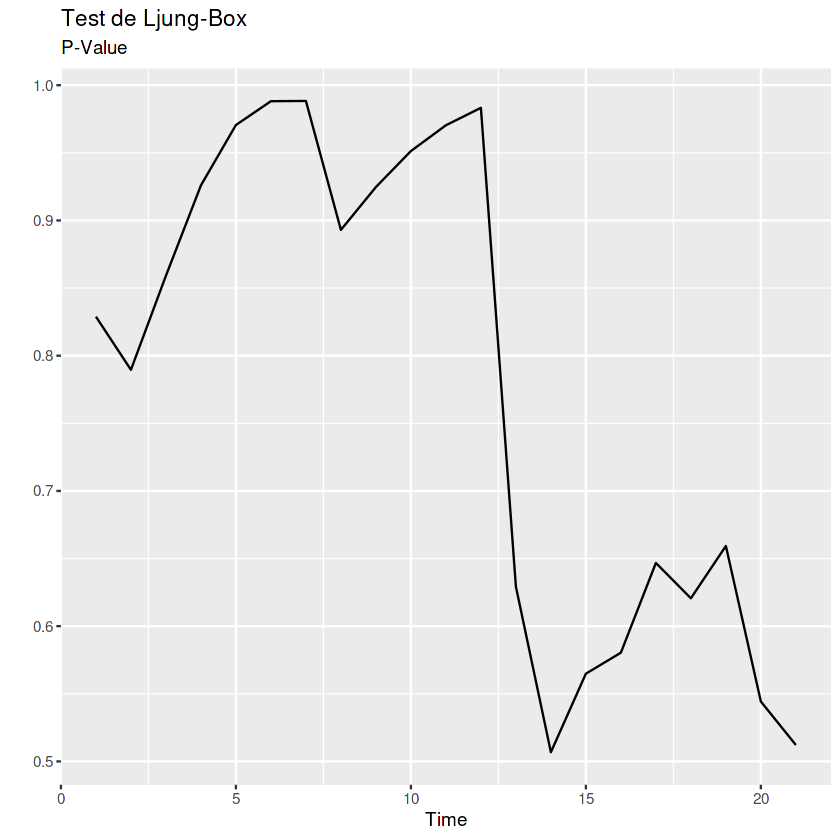

In [20]:
qqnorm(residuals(Arimaforecast))
qqline(residuals(Arimaforecast))

adf.test(Arimaforecast$residuals, alternative = "stationary")

checkresiduals(Arimaforecast)

# Otra forma
residuos <- resid(Arimaforecast)

Histogram(residuos, density = T, main = "Histograma de Residuos")

# jarque.bera.test(na.omit(residuos))
Normality_Test(na.omit(residuos), type = "JB")
Normality_Test(na.omit(residuos), type = "AD")
Normality_Test(na.omit(residuos), type = "SW")

# Exploratory Data Analysis
summary(residuos)

# Gr?ficos de los residuos, ACF, PACF y qq norm
plot(Arimaforecast$residuals, main = "Grafico de los Residuos")
acf(Arimaforecast$residuals, na.action = na.pass)
pacf(Arimaforecast$residuals, na.action = na.pass)
qqnorm(Arimaforecast$residuals)

# Testeo de Incorrelaci?n de los Residuos
Incorrelation(residuos, "Ljung-Box")
inco_wn <- Incorrelation(residuos, "Ljung-Box")
autoplot(ts(inco_wn$P_Value)) + ggtitle("Test de Ljung-Box", subtitle = "P-Value") + ylab("")